# Исследование свойст характеристики

## Подготовим вспомогательные инструменты для дальнейших исллдеований

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from scipy.stats import skewnorm

Генерация случайных величин, которые имеют распределение $Normal(0,σ)$ и $SkewNormal(α)$

In [ ]:
def generate_normal(n, sigma):
  return np.random.normal(0, sigma, n)

# Плохо для параллельных вычислений
# def generate_skewnormal(n, alpha):
#   return skewnorm.rvs(alpha, size=n)

# https://stackoverflow.com/questions/36200913/generate-n-random-numbers-from-a-skew-normal-distribution-using-numpy
# literal adaption from:
# http://stackoverflow.com/questions/4643285/how-to-generate-random-numbers-that-follow-skew-normal-distribution-in-matlab
# original at:
# http://www.ozgrid.com/forum/showthread.php?t=108175
def rand_skew_norm(fAlpha, fLocation, fScale):
    sigma = fAlpha / np.sqrt(1.0 + fAlpha**2) 

    afRN = np.random.randn(2)
    u0 = afRN[0]
    v = afRN[1]
    u1 = sigma*u0 + np.sqrt(1.0 -sigma**2) * v 

    if u0 >= 0:
        return u1*fScale + fLocation 
    return (-u1)*fScale + fLocation 

def generate_skewnormal(N, skew=0.0):
    return [rand_skew_norm(skew, 0, 1) for x in range(N)]

**Построение KNN-графа** \
Построим KNN-граф на нашей случайной выборке $\Xi$

In [5]:
def build_knn_graph(k, vertices):
    v = np.asarray(vertices, dtype=float).reshape(-1, 1)
    n = v.shape[0]

    nbrs = NearestNeighbors(n_neighbors=k+1).fit(v)
    distances, indices = nbrs.kneighbors(v)

    G = nx.Graph()
    G.add_nodes_from(range(n))

    for i in range(n):
        for j in indices[i][1:]:
            G.add_edge(i, j)

    return G

Функция, которая вычисляет число треугольников в графе

In [6]:
def count_triangles(G: nx.Graph) -> int:
    tr_per_node = nx.triangles(G)
    total_trs = sum(tr_per_node.values()) // 3
    return total_trs

**Построение дистанционного графа** \
Построим дистанционный граф на нашей случайной выборке $\Xi$

In [7]:
def build_distance_graph(d, vertices):
    v = np.asarray(vertices)
    n = v.size

    G = nx.Graph()
    G.add_nodes_from(range(n))

    for i in range(n):
        for j in range(i+1, n):
            if abs(v[i] - v[j]) <= d:
                G.add_edge(i, j)

    return G

Функция, которая вычисляет хроматическое число графа

In [8]:
def chromatic_number(G: nx.Graph) -> int:
    """
    Функция для поиска хроматического числа графа G
    """
    coloring = nx.coloring.greedy_color(G, strategy='largest_first')
    return max(coloring.values(), default=-1) + 1

**метод Монте-Карло**

In [9]:
def monte_carlo(M, n, distr_param, graph_param, gen_func, graph_func, res_func):
  """
  Функция для реализации метода Монте-Карло.
  M - кол-во исследований.
  n - кол-во вершин в графе.
  distr_param - distribution parameter, параметр распределения.
  graph_param - параметр графа, то есть k - для KNN-графа или d - для дистанционного графа.
  gen_func - функция для генерации реализации распределения: genrate_lognormal или genrate_exp.
  graph_func - функция для построения графа: build_knn_graph или build_distance_graph.
  res_func - функция для вычисления характеристики графа: min_degree или get_clique_number.
  """
  results = []
  for _ in range(M):
    vertices = gen_func(n, distr_param)
    G = graph_func(graph_param, vertices)
    results.append(res_func(G))
  return results

In [10]:
from joblib import Parallel, delayed

def monte_carlo_step(n, distr_param, graph_param, gen_func, graph_func, res_func):
    vertices = gen_func(n, distr_param)
    G = graph_func(graph_param, vertices)
    return res_func(G)

def monte_carlo_multiprocessing(M, n, distr_param, graph_param, gen_func, graph_func, res_func):
  """
  Функция для реализации метода Монте-Карло с параллельными вычислениями.
  M - кол-во исследований.
  n - кол-во вершин в графе.
  distr_param - distribution parameter, параметр распределения.
  graph_param - параметр графа, то есть k - для KNN-графа или d - для дистанционного графа.
  gen_func - функция для генерации реализации распределения: genrate_lognormal или genrate_exp.
  graph_func - функция для построения графа: build_knn_graph или build_distance_graph.
  res_func - функция для вычисления характеристики графа: min_degree или get_clique_number.
  """
  results = Parallel(n_jobs=-1)(delayed(monte_carlo_step)(n, distr_param, graph_param, gen_func, graph_func, res_func) for _ in range(M))
  return results

Функция для вычисления базовых статистических метрик: среднее значение, дисперсия, стандартное отклонение, стандартная ошибка среднего.

In [11]:
import math

def compute_stats(arr):
    mean = np.mean(arr)
    var = np.var(arr, ddof=1)
    std = math.sqrt(var)
    se = std / math.sqrt(len(arr))
    return mean, var, std, se

Функция для анализа результатов и построения гистограммы.

In [12]:
def analyze(n, graph_param, exp_results, lognormal_results, need_hist=True):
    mean_exp, var_exp, std_exp, se_exp = compute_stats(exp_results)
    mean_log, var_log, std_log, se_log = compute_stats(lognormal_results)
    p95_exp = np.percentile(exp_results, 95)
    threshold = (mean_exp + mean_log) / 2

    alpha = np.mean(exp_results > p95_exp)
    power = np.mean(lognormal_results > p95_exp)


    metrics = {
        'n': n, 'graph_param': graph_param,
        'power': power,
        'alpha': alpha,
        'p95_exp': p95_exp,
        'threshold': threshold,
        'mean_exp': mean_exp, 'var_exp': var_exp, 'std_exp': std_exp, 'se_exp': se_exp,
        'mean_log': mean_log, 'var_log': var_log, 'std_log': std_log, 'se_log': se_log,
    }

    if not need_hist:
        return metrics

    fig, ax = plt.subplots(figsize=(8, 5))
    bins = 'auto'

    ax.hist(exp_results, bins=bins, alpha=0.6, label='exp_results', density=True)
    ax.hist(lognormal_results, bins=bins, alpha=0.6, label='lognormal_results', density=True)

    ax.axvline(p95_exp, color='red', linestyle='--',
                label=f'95% exp ({p95_exp:.2f})')
    
    ax.axvline(threshold, color='darkblue', alpha=0.5, linestyle=':',
                label=f'threshold ({threshold:.2f})')

    ax.set_title(f'Гистограмма для n={n}, параметр графа={graph_param}\nМощность={power}, ошибка первого рода={alpha}')
    ax.set_xlabel('Значение характеристики')
    ax.set_ylabel('Плотность (frequency density)')
    ax.legend()
    plt.tight_layout()
    plt.show()

    return metrics

## Исследуем, как ведет себя $Τ$ в зависимости от параметров процедуры построения графа и размера выборки

Зафиксируем параметры распределения:
* $Normal(0,σ)$, $\; \sigma_0 = 1$
* $SkewNormal(α)$, $\; \alpha_0 = 1$

In [13]:
import math

sigma0 = 1
alpha0 = 1

#### Исследуем дистанционный-граф

In [14]:
M = 500
n_array = [25, 100, 500, 1000]
d_array = [
    [0.2, 0.4, 0.6],
    [0.1, 0.2, 0.3],
    [0.05, 0.1, 0.15],
    [0.01, 0.05, 0.1]
]

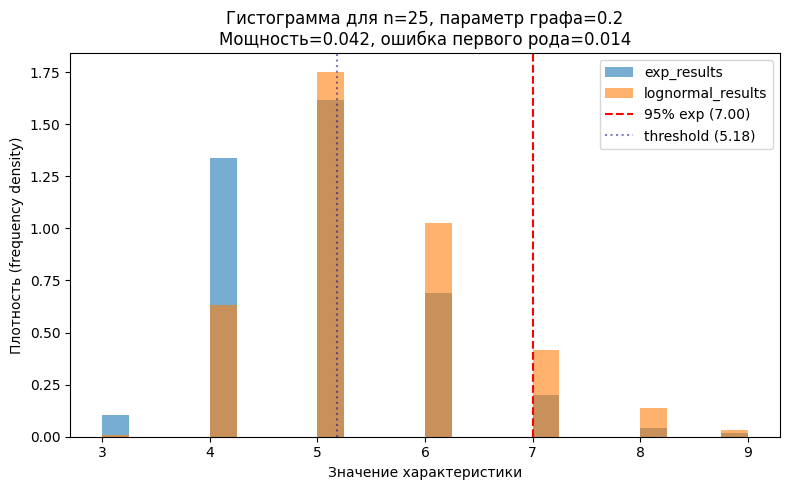

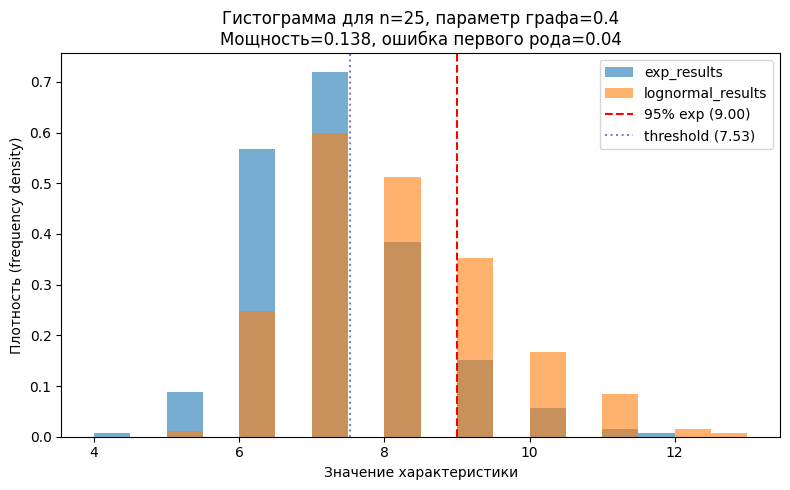

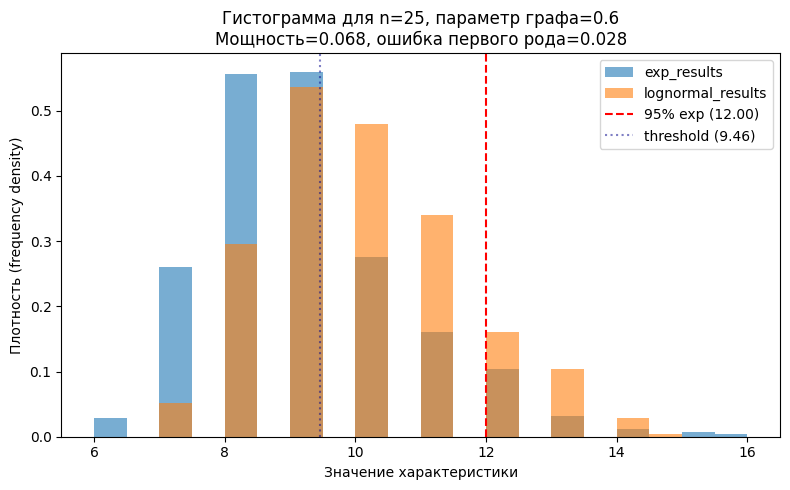

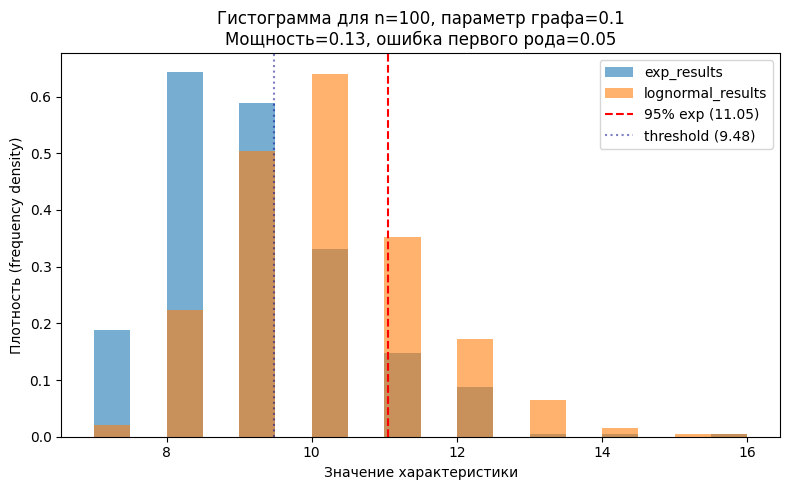

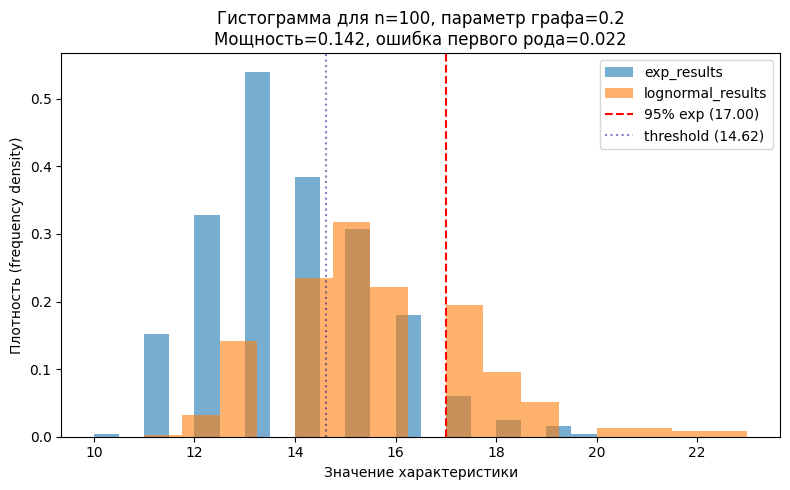

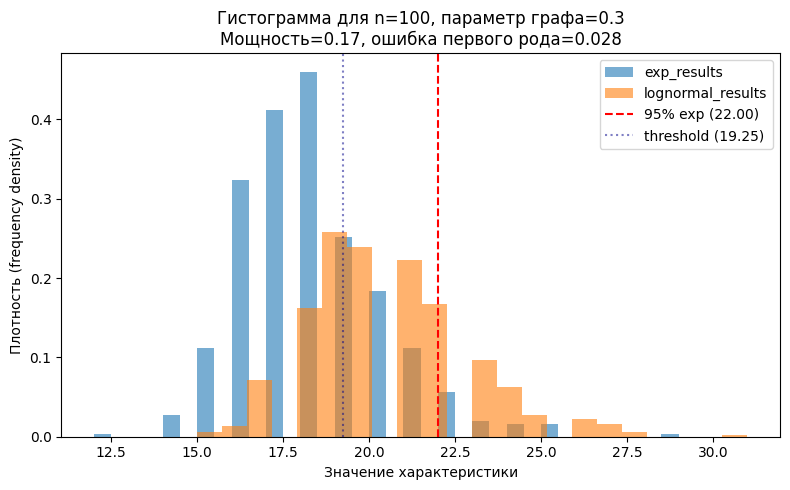

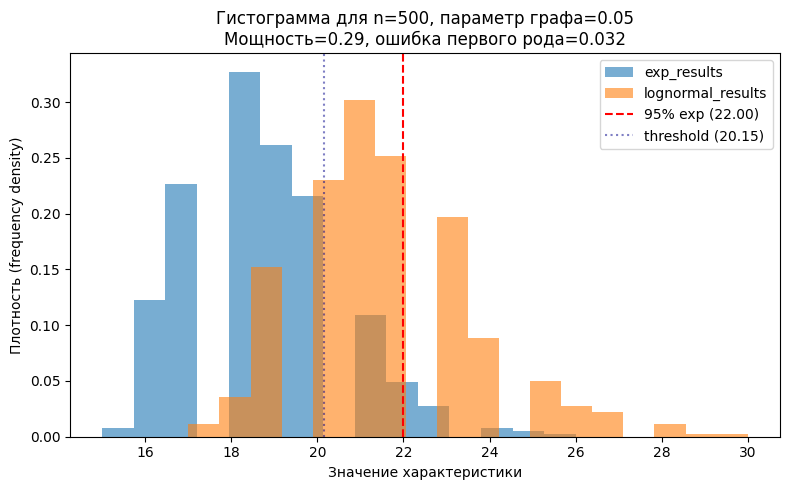

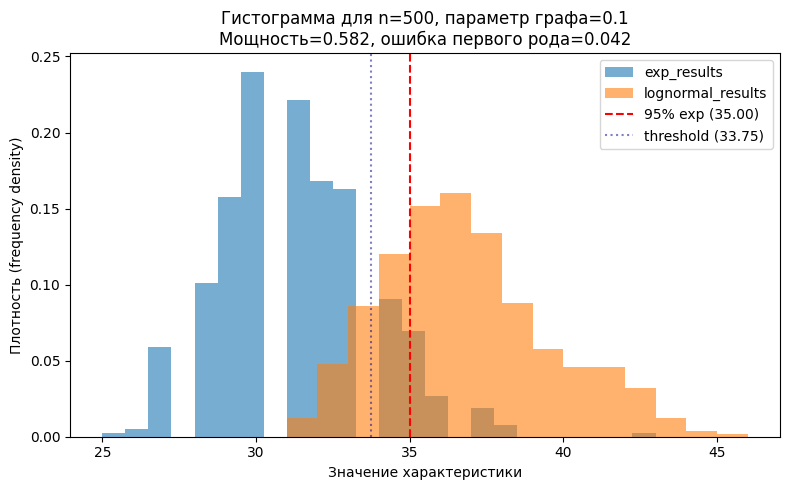

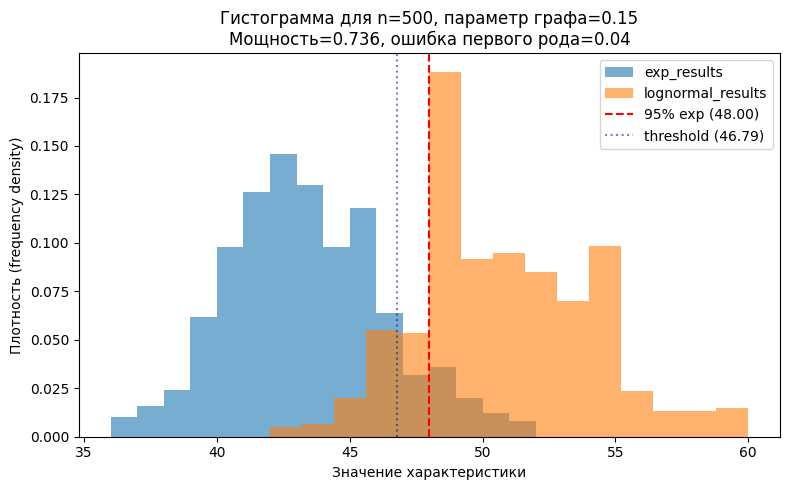

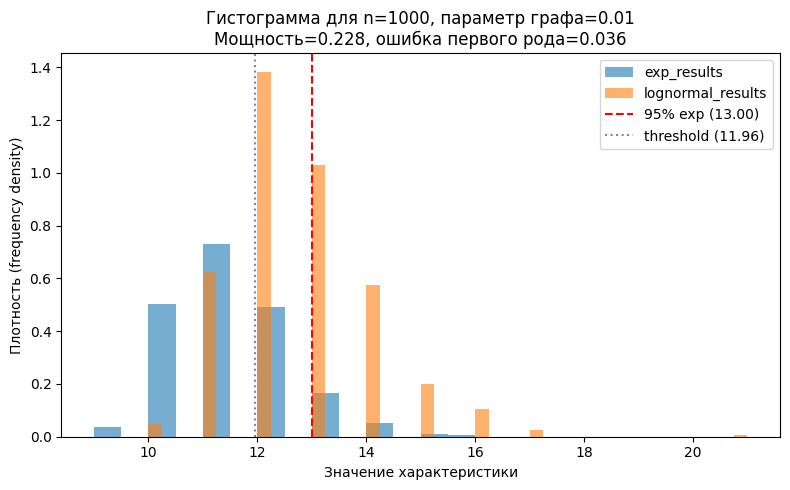

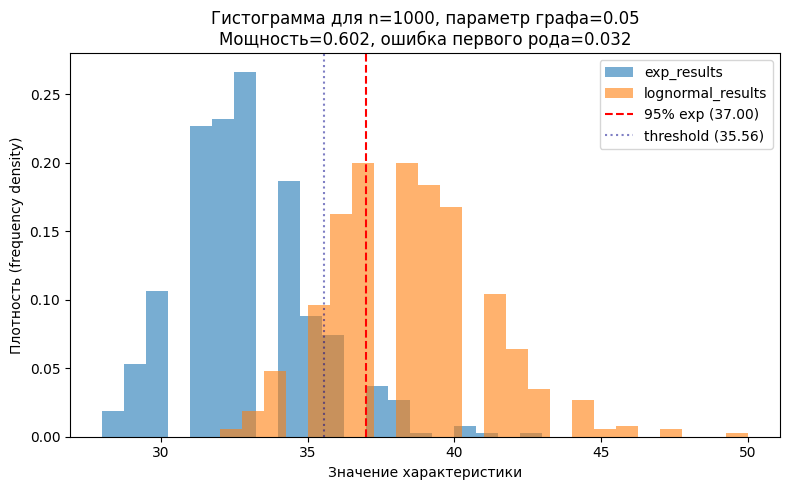

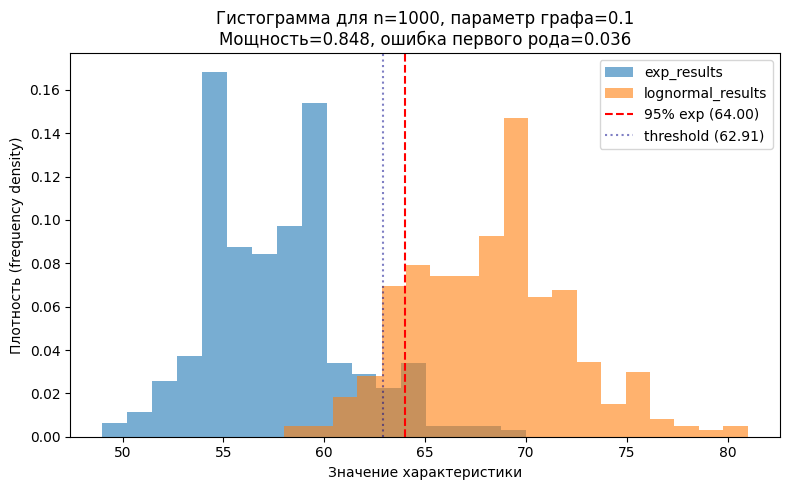

In [16]:
metrics_dist = []

for i, n in enumerate(n_array):
    for d in d_array[i]:
        normal_results = monte_carlo(M, n, sigma0, d, generate_normal, build_distance_graph, chromatic_number)
        skewnormal_results = monte_carlo(M, n, alpha0, d, generate_skewnormal, build_distance_graph, chromatic_number)
        metrics_dist.append(analyze(n, d, normal_results, skewnormal_results))


Выведем таблицу с основными статистическими метриками:

In [17]:
df_metrics = pd.DataFrame(metrics_dist)

In [18]:
df_metrics

n  graph_param  power  alpha  p95_exp  threshold  mean_exp    var_exp  \
0     25         0.20  0.042  0.014     7.00      5.184     4.932   0.961299   
1     25         0.40  0.138  0.040     9.00      7.526     7.096   1.465715   
2     25         0.60  0.068  0.028    12.00      9.458     9.006   2.502970   
3    100         0.10  0.130  0.050    11.05      9.480     8.968   1.738453   
4    100         0.20  0.142  0.022    17.00     14.624    13.690   2.799499   
5    100         0.30  0.170  0.028    22.00     19.247    18.000   4.280561   
6    500         0.05  0.290  0.032    22.00     20.150    18.708   3.245226   
7    500         0.10  0.582  0.042    35.00     33.752    31.180   5.835271   
8    500         0.15  0.736  0.040    48.00     46.786    42.882   8.673423   
9   1000         0.01  0.228  0.036    13.00     11.956    11.244   1.271006   
10  1000         0.05  0.602  0.032    37.00     35.556    32.758   5.065567   
11  1000         0.10  0.848  0.036    64.00     62.911    57.550  12.199900   

     std_exp    se_exp  mean_log    var_log   std_log    se_log  
0   0.980458  0.043847     5.436   1.084072  1.041188  0.046563  
1   1.210667  0.054143     7.956   1.970004  1.403568  0.062769  
2   1.582078  0.070753     9.910   2.322545  1.523990  0.068155  
3   1.318504  0.058965     9.992   1.851639  1.360750  0.060855  
4   1.673170  0.074826    15.558   3.838313  1.959161  0.087616  
5   2.068952  0.092526    20.494   5.332629  2.309249  0.103273  
6   1.801451  0.080563    21.592   4.286108  2.070292  0.092586  
7   2.415630  0.108030    36.324   7.473972  2.733857  0.122262  
8   2.945068  0.131707    50.690  11.015932  3.319026  0.148431  
9   1.127389  0.050418    12.668   1.773323  1.331662  0.059554  
10  2.250681  0.100654    38.354   6.918521  2.630308  0.117631  
11  3.492835  0.156204    68.272  15.152321  3.892598  0.174082

**Вывод:**\
Если говорить про зависимость метрик от `n`, то может где-то участками можно заметить рост, но определить тип зависимости на имеющихся данных пока тяжело. Аналогично коллеге я бы зафиксировал оптимальный `n = 500`, а также разобрался с `d`. Падение плотности при увеличении `d` заметно, особенно в случае с `n = 1000`, поэтому предлагаю проверить их зависимость. Разница будет в том, я смотрю по хроматическому числу, а мой коллега смотрел по кликовому числу.

Скорость расчетов уже довольно низкая, поэтому у моего коллеги Филиппа появилась идея распараллелить все вычисления.

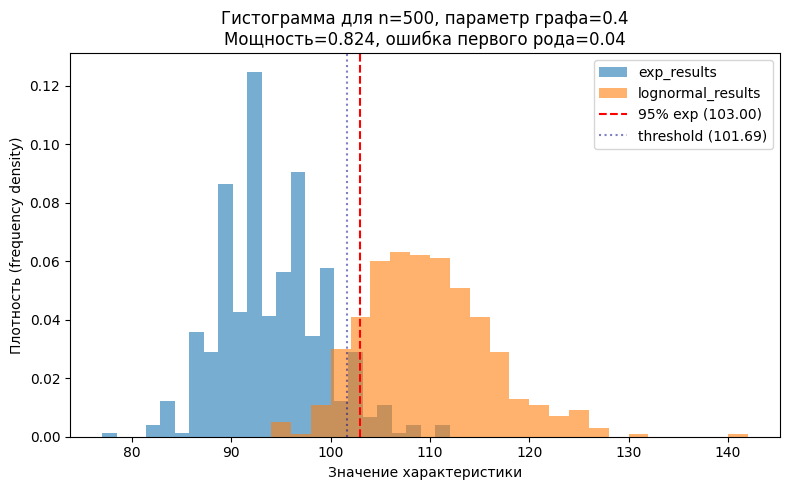

In [43]:
M = 500
N = 500
D = 0.4
metrics_dist_500 = []

normal_results = monte_carlo(M, N, sigma0, D, generate_normal, build_distance_graph, chromatic_number)
skewnormal_results = monte_carlo(M, N, alpha0, D, generate_skewnormal, build_distance_graph, chromatic_number)
metrics_dist_500.append(analyze(N, D, normal_results, skewnormal_results))

Данный код отработал примерно за `2` минуты, посмотрим, сколько потребуется времени параллельному методу Монте-Карло.

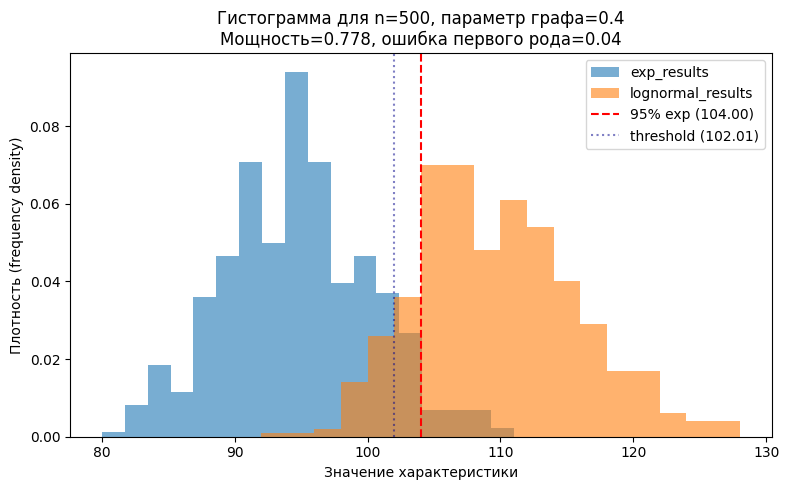

In [44]:
M = 500
N = 500
D = 0.4

normal_results = monte_carlo_multiprocessing(M, N, sigma0, D, generate_normal, build_distance_graph, chromatic_number)
skewnormal_results = monte_carlo_multiprocessing(M, N, alpha0, D, generate_skewnormal, build_distance_graph, chromatic_number)
metrics_dist_500.append(analyze(N, D, normal_results, skewnormal_results))

In [45]:
df_metrics = pd.DataFrame(metrics_dist_500)

In [46]:
df_metrics

n  graph_param  power  alpha  p95_exp  threshold  mean_exp    var_exp  \
0  500          0.4  0.824   0.04    103.0    101.688    94.108  26.064465   
1  500          0.4  0.778   0.04    104.0    102.007    94.738  29.961279   

    std_exp    se_exp  mean_log    var_log   std_log    se_log  
0  5.105337  0.228318   109.268  39.984144  6.323302  0.282787  
1  5.473690  0.244791   109.276  36.989804  6.081924  0.271992

Параллельный метод Монте-Карло отработал за 40 секунд при `n = 500` и `d = 0.4`, то есть мы получили прирост в скорости примерно в 3 раза. Теперь можем быстро посчитать, как влияет параметр `d` на метрики при фиксированном `n`.

In [47]:
M = 500
N = 500
d_array = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

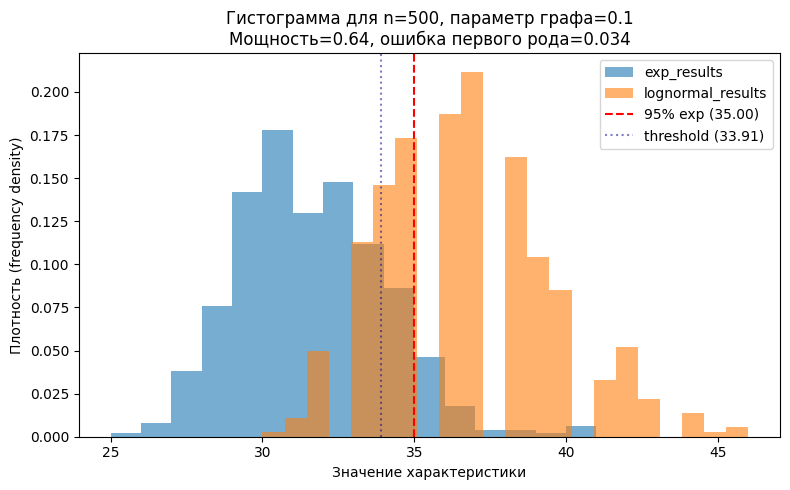

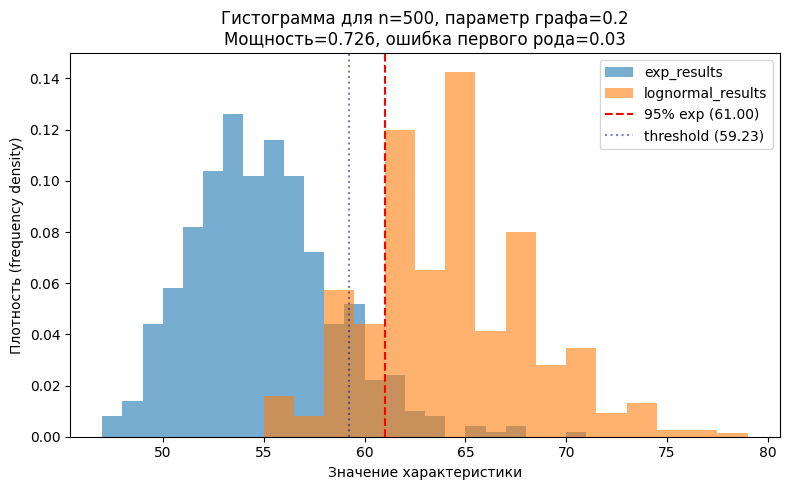

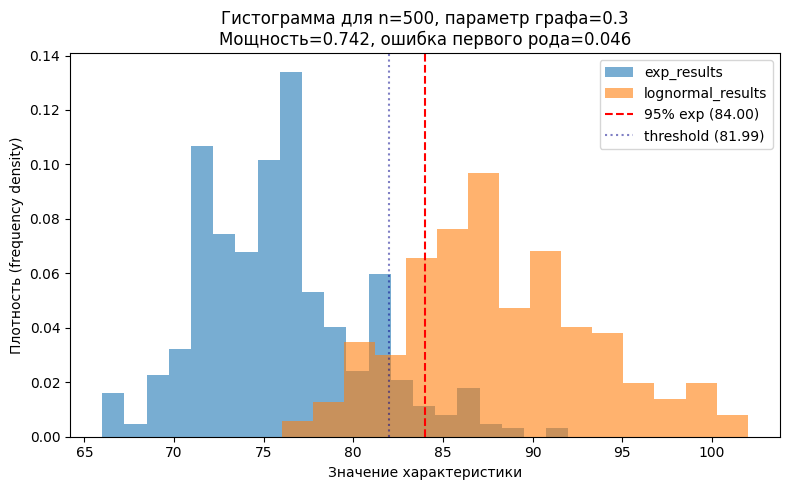

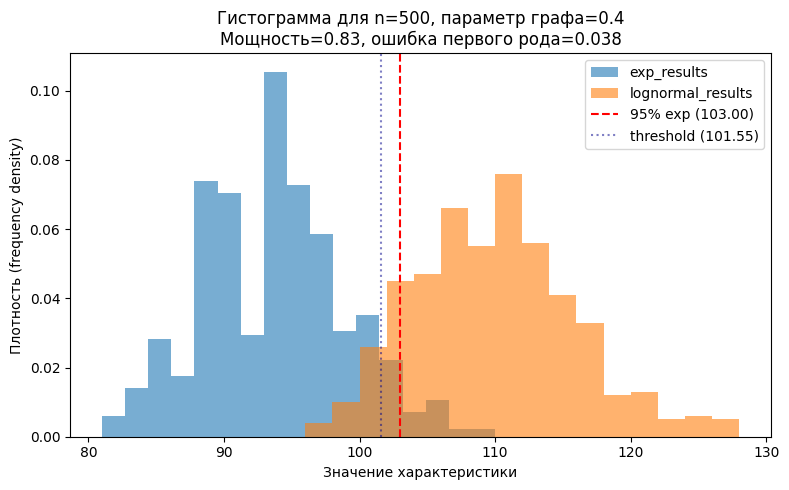

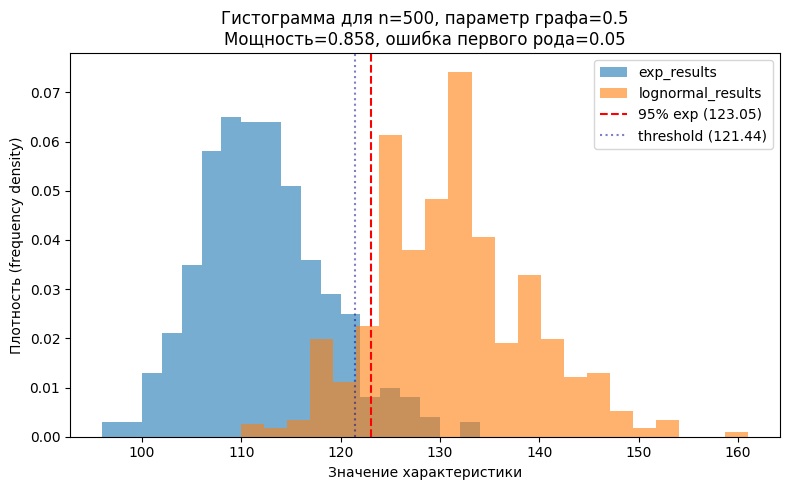

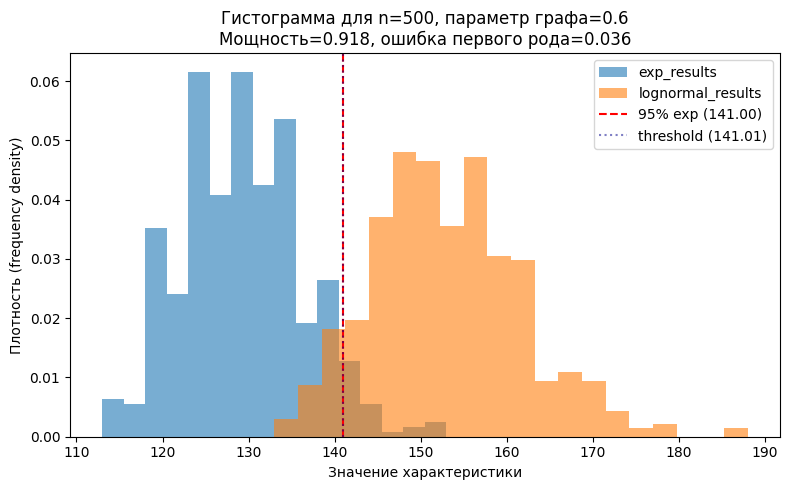

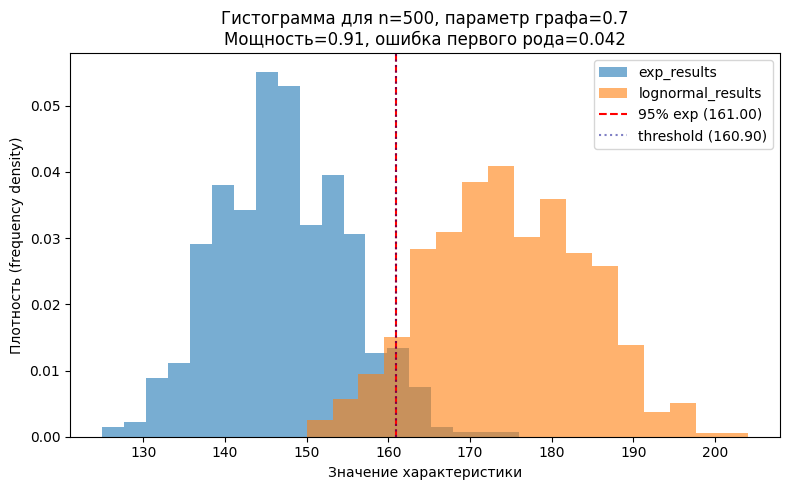

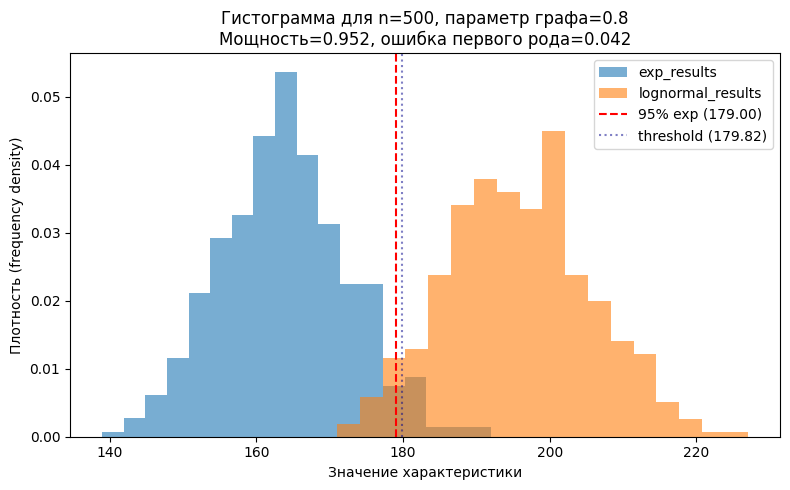

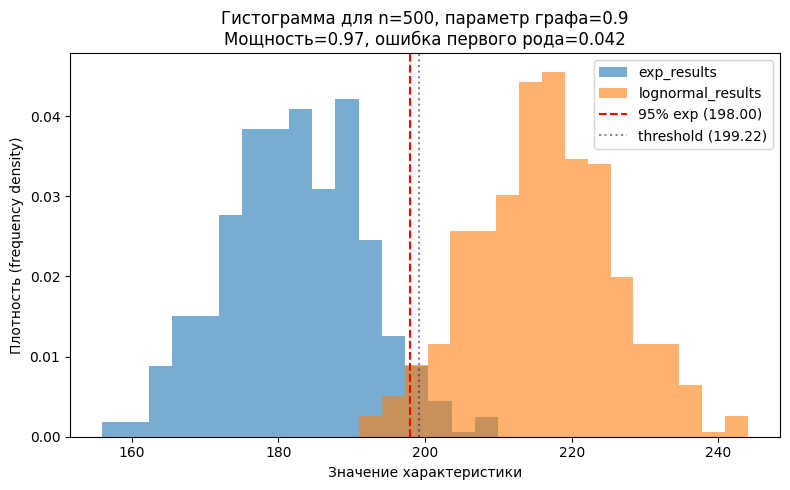

In [50]:
metrics_dist_500 = []

for d in d_array:
    normal_results = monte_carlo_multiprocessing(M, N, sigma0, d, generate_normal, build_distance_graph, chromatic_number)
    skewnormal_results = monte_carlo_multiprocessing(M, N, alpha0, d, generate_skewnormal, build_distance_graph, chromatic_number)
    metrics_dist_500.append(analyze(N, d, normal_results, skewnormal_results))

df_metrics = pd.DataFrame(metrics_dist_500)

In [51]:
df_metrics

n  graph_param  power  alpha  p95_exp  threshold  mean_exp    var_exp  \
0  500          0.1  0.640  0.034    35.00     33.910    31.136   5.889283   
1  500          0.2  0.726  0.030    61.00     59.235    54.406  12.522208   
2  500          0.3  0.742  0.046    84.00     81.993    75.850  20.692886   
3  500          0.4  0.830  0.038   103.00    101.550    93.648  27.799695   
4  500          0.5  0.858  0.050   123.05    121.437   111.624  39.645916   
5  500          0.6  0.918  0.036   141.00    141.008   129.072  48.267351   
6  500          0.7  0.910  0.042   161.00    160.898   147.134  63.310665   
7  500          0.8  0.952  0.042   179.00    179.819   163.870  77.848798   
8  500          0.9  0.970  0.042   198.00    199.221   182.178  87.669655   

    std_exp    se_exp  mean_log    var_log   std_log    se_log  
0  2.426784  0.108529    36.684   7.940024  2.817805  0.126016  
1  3.538673  0.158254    64.064  16.336577  4.041853  0.180757  
2  4.548943  0.203435    88.136  27.937379  5.285582  0.236378  
3  5.272542  0.235795   109.452  34.881459  5.906053  0.264127  
4  6.296500  0.281588   131.250  60.380261  7.770474  0.347506  
5  6.947471  0.310700   152.944  76.774413  8.762101  0.391853  
6  7.956800  0.355839   174.662  90.761279  9.526871  0.426055  
7  8.823197  0.394585   195.768  97.304786  9.864319  0.441146  
8  9.363208  0.418735   216.264  92.719743  9.629109  0.430627

Мне кажется, стоит посмотреть больше значений `d`

In [52]:
M = 500
N = 500
d_array = [1, 1.1, 1.2, 1.3, 1.4, 1.5]

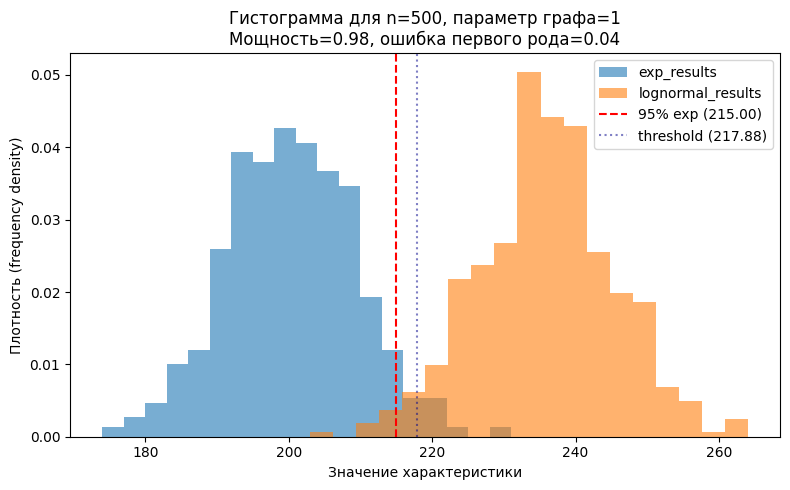

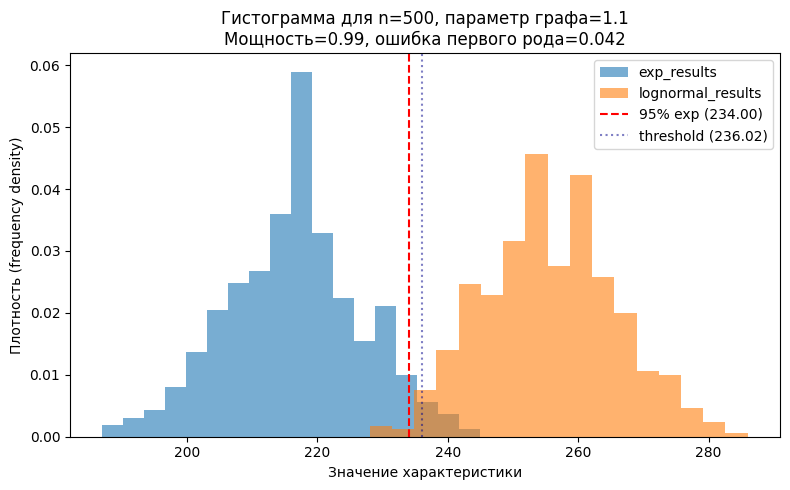

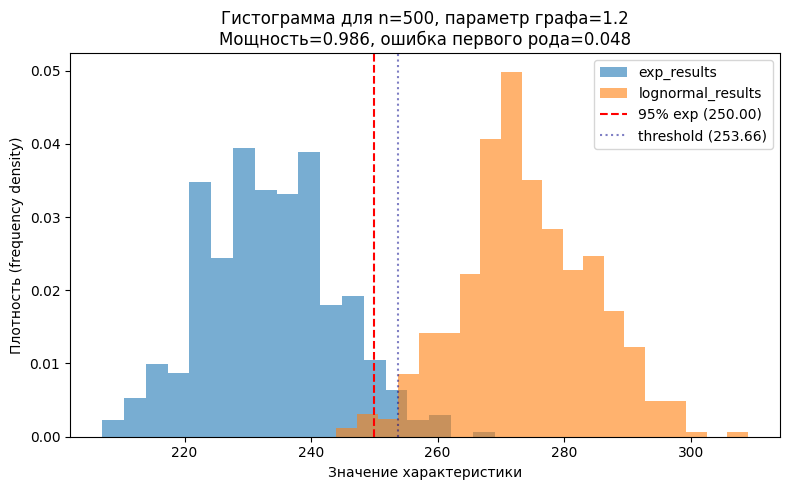

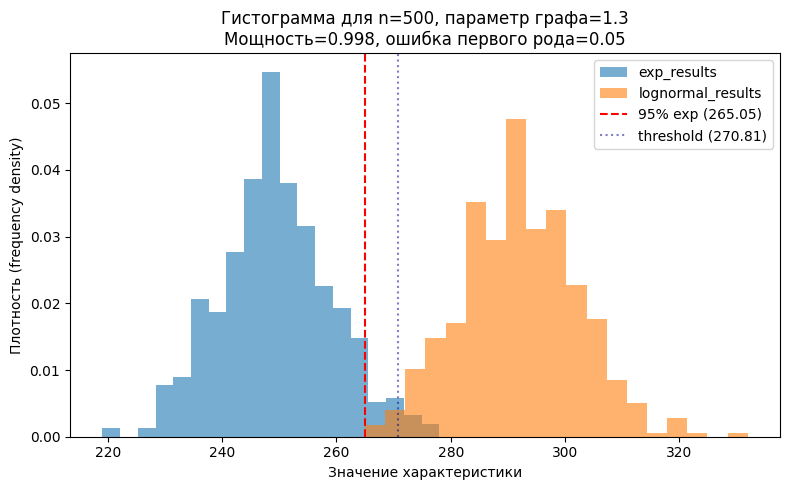

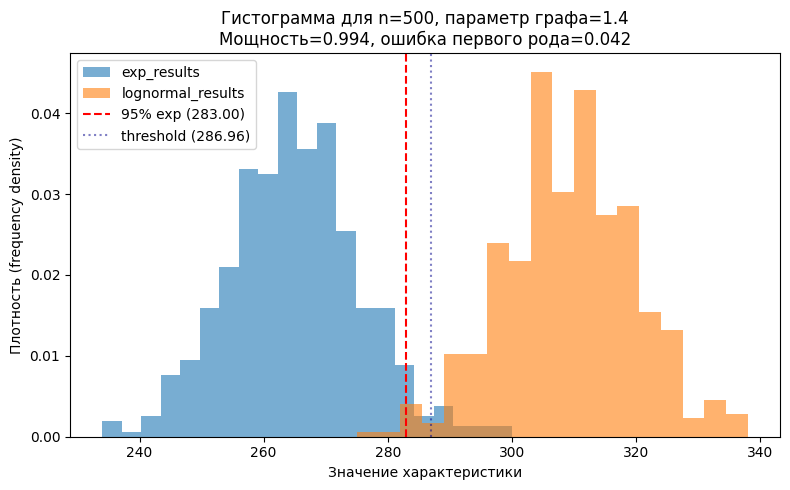

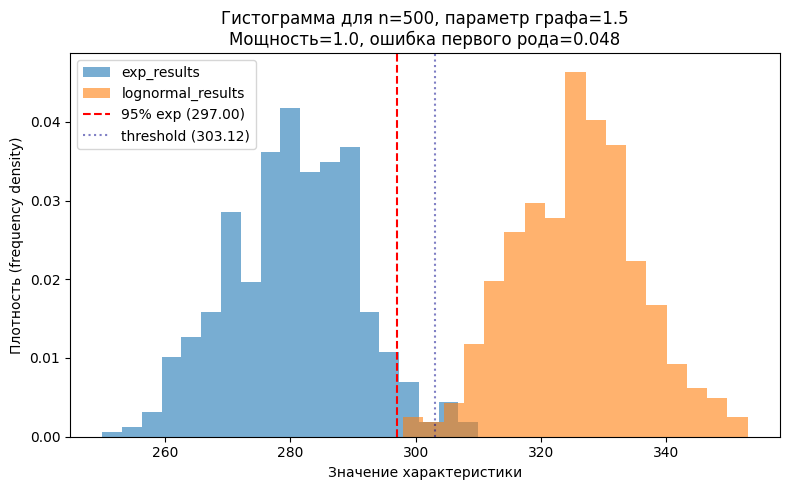

In [53]:
metrics_dist_500 = []

for d in d_array:
    normal_results = monte_carlo_multiprocessing(M, N, sigma0, d, generate_normal, build_distance_graph, chromatic_number)
    skewnormal_results = monte_carlo_multiprocessing(M, N, alpha0, d, generate_skewnormal, build_distance_graph, chromatic_number)
    metrics_dist_500.append(analyze(N, d, normal_results, skewnormal_results))

df_metrics_2 = pd.DataFrame(metrics_dist_500)

In [54]:
df_metrics

n  graph_param  power  alpha  p95_exp  threshold  mean_exp    var_exp  \
0  500          0.1  0.640  0.034    35.00     33.910    31.136   5.889283   
1  500          0.2  0.726  0.030    61.00     59.235    54.406  12.522208   
2  500          0.3  0.742  0.046    84.00     81.993    75.850  20.692886   
3  500          0.4  0.830  0.038   103.00    101.550    93.648  27.799695   
4  500          0.5  0.858  0.050   123.05    121.437   111.624  39.645916   
5  500          0.6  0.918  0.036   141.00    141.008   129.072  48.267351   
6  500          0.7  0.910  0.042   161.00    160.898   147.134  63.310665   
7  500          0.8  0.952  0.042   179.00    179.819   163.870  77.848798   
8  500          0.9  0.970  0.042   198.00    199.221   182.178  87.669655   

    std_exp    se_exp  mean_log    var_log   std_log    se_log  
0  2.426784  0.108529    36.684   7.940024  2.817805  0.126016  
1  3.538673  0.158254    64.064  16.336577  4.041853  0.180757  
2  4.548943  0.203435    88.136  27.937379  5.285582  0.236378  
3  5.272542  0.235795   109.452  34.881459  5.906053  0.264127  
4  6.296500  0.281588   131.250  60.380261  7.770474  0.347506  
5  6.947471  0.310700   152.944  76.774413  8.762101  0.391853  
6  7.956800  0.355839   174.662  90.761279  9.526871  0.426055  
7  8.823197  0.394585   195.768  97.304786  9.864319  0.441146  
8  9.363208  0.418735   216.264  92.719743  9.629109  0.430627

In [55]:
df_metrics_2

n  graph_param  power  alpha  p95_exp  threshold  mean_exp     var_exp  \
0  500          1.0  0.980  0.040   215.00    217.876   199.874   81.044212   
1  500          1.1  0.990  0.042   234.00    236.021   216.394  105.020806   
2  500          1.2  0.986  0.048   250.00    253.660   233.400  106.200401   
3  500          1.3  0.998  0.050   265.05    270.815   249.402   96.104605   
4  500          1.4  0.994  0.042   283.00    286.962   264.954  111.567018   
5  500          1.5  1.000  0.048   297.00    303.125   280.516  107.508762   

     std_exp    se_exp  mean_log     var_log    std_log    se_log  
0   9.002456  0.402602   235.878   90.207531   9.497765  0.424753  
1  10.247966  0.458303   255.648  100.721539  10.036012  0.448824  
2  10.305358  0.460870   273.920  106.454509  10.317679  0.461421  
3   9.803296  0.438417   292.228  104.945908  10.244311  0.458140  
4  10.562529  0.472371   308.970  109.391884  10.459057  0.467743  
5  10.368643  0.463700   325.734   98.929102   9.946311  0.444813

**Выводы:**\
Установить какую-то адекватную связь здесь не получится, мы видим только рост `p95_exp` и `threshold`. Получилось аналогичное наблюдение, как и в случае с кликовым числом — есть критический порог.

Поэтому в дальнейших экспериментах я считаю разумно рассматривать дистанционные графы, в которых `d = 0.9` (критический порог), так как это идеальный компромисс между качеством предсказания и скоростью работы.

In [56]:
M = 500
D = 0.9
n_array = [25, 100, 500]

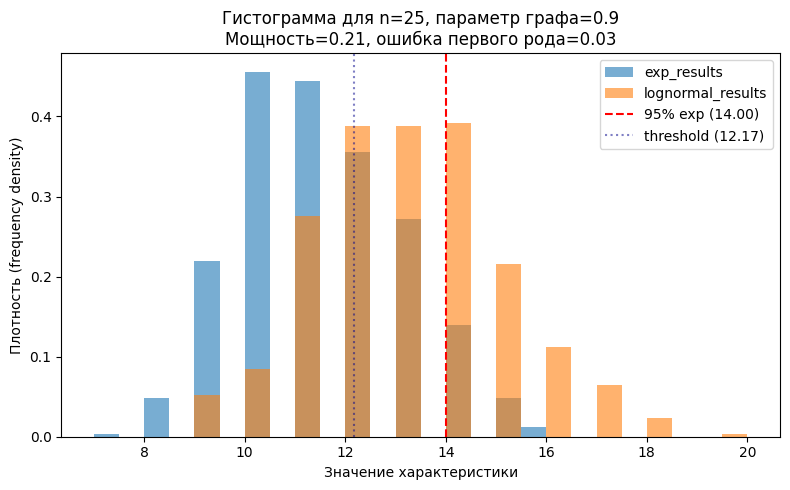

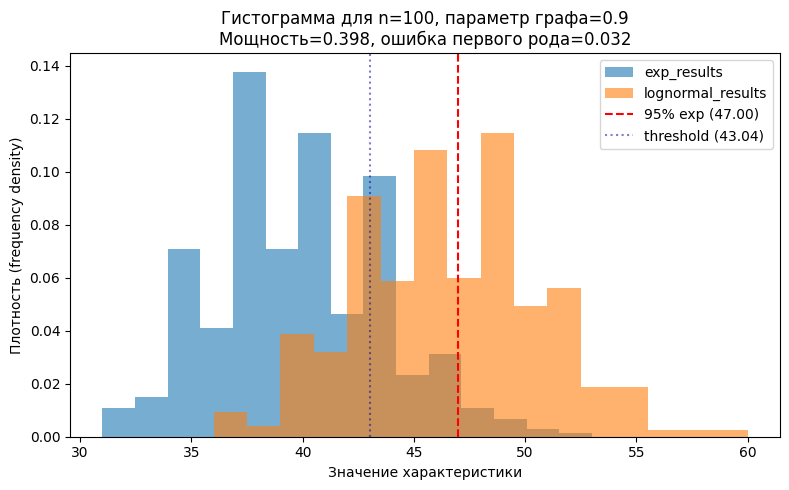

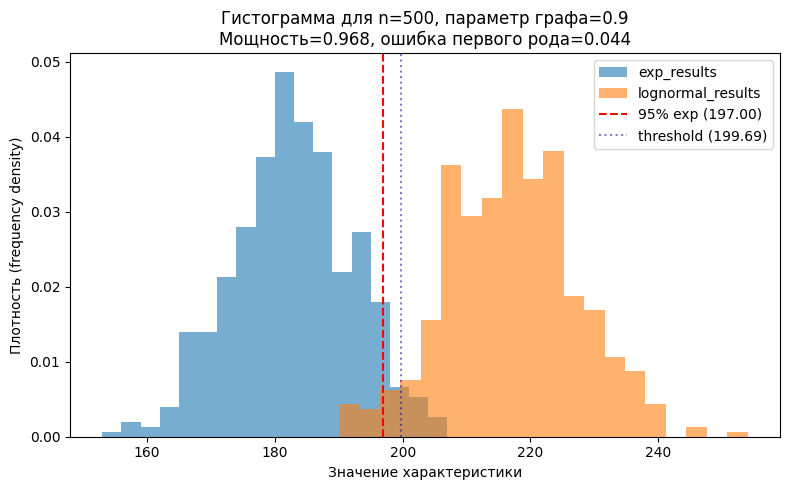

In [57]:
metrics_dist_final = []

for n in n_array:
    normal_results = monte_carlo_multiprocessing(M, n, sigma0, D, generate_normal, build_distance_graph, chromatic_number)
    skewnormal_results = monte_carlo_multiprocessing(M, n, alpha0, D, generate_skewnormal, build_distance_graph, chromatic_number)
    metrics_dist_final.append(analyze(n, D, normal_results, skewnormal_results))

df_metrics = pd.DataFrame(metrics_dist_final)

#### Исследуем KNN-граф

In [61]:
M = 500
n_array = [25, 100, 500]
k_array = [
    [2, 4, 7, 8, 9, 10, 12, 13, 16, 17, 22],
    [10, 12, 13, 16, 17, 22, 32, 64, 71],
    [32, 64, 100]
]

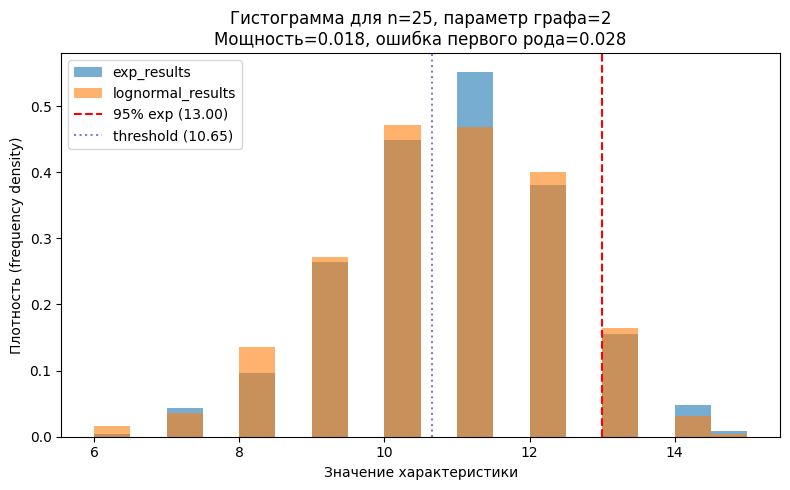

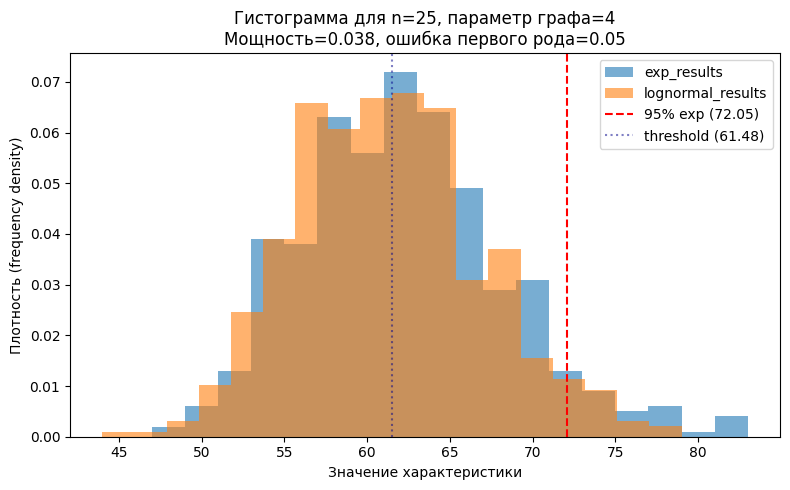

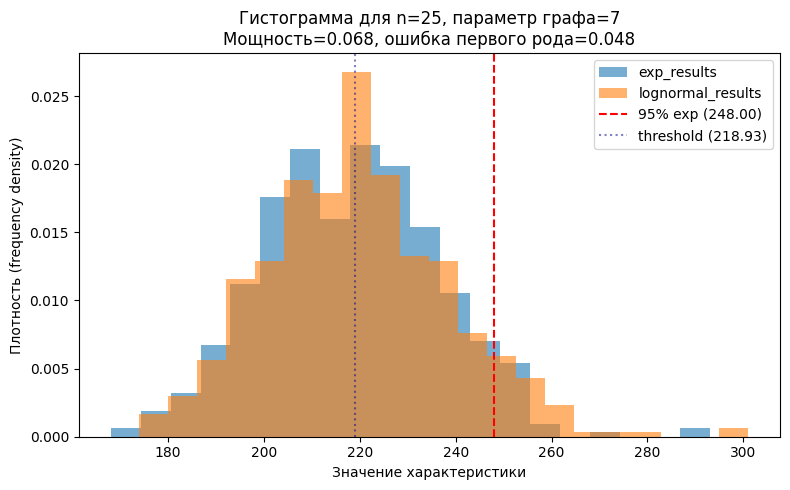

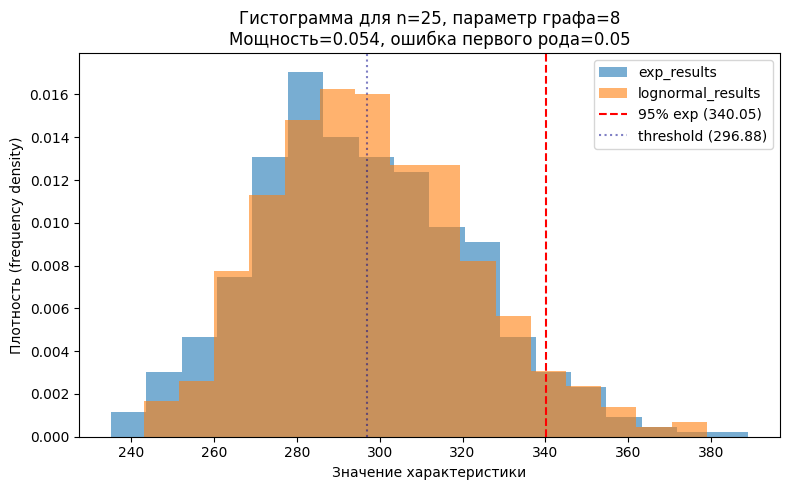

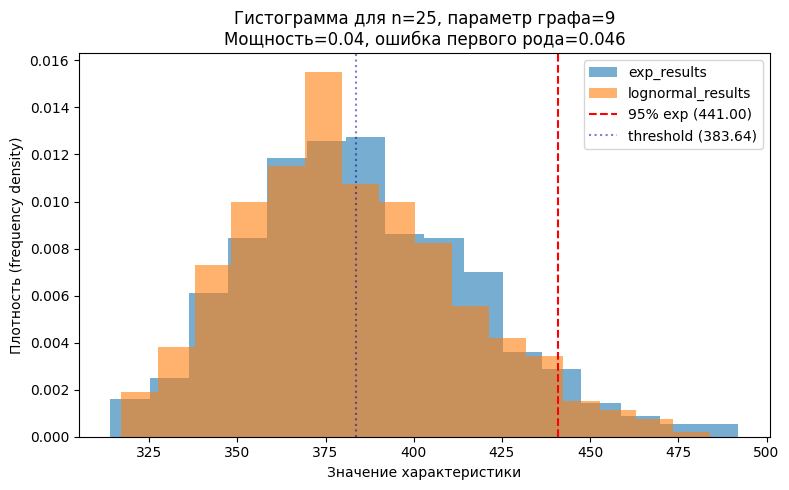

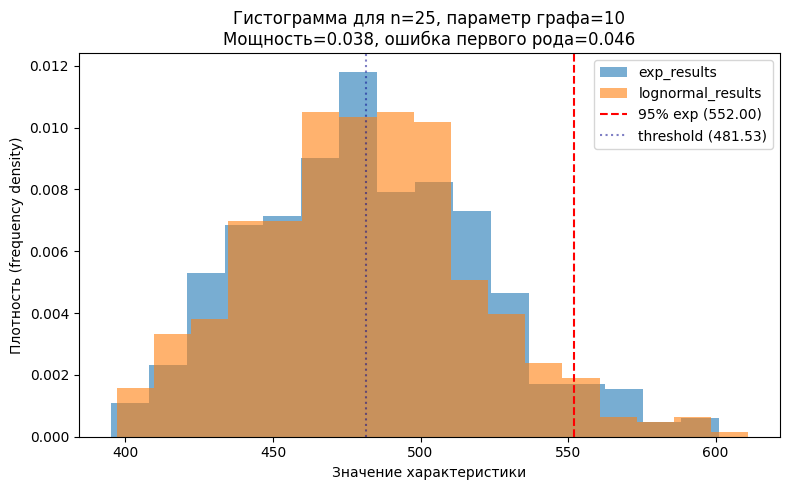

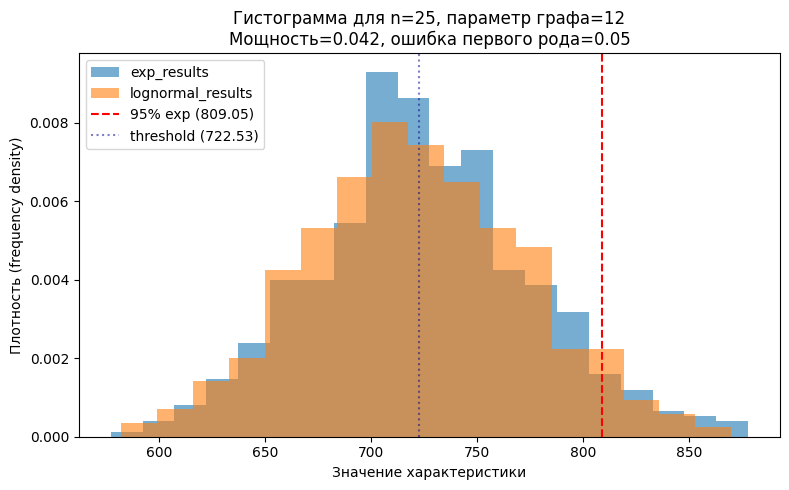

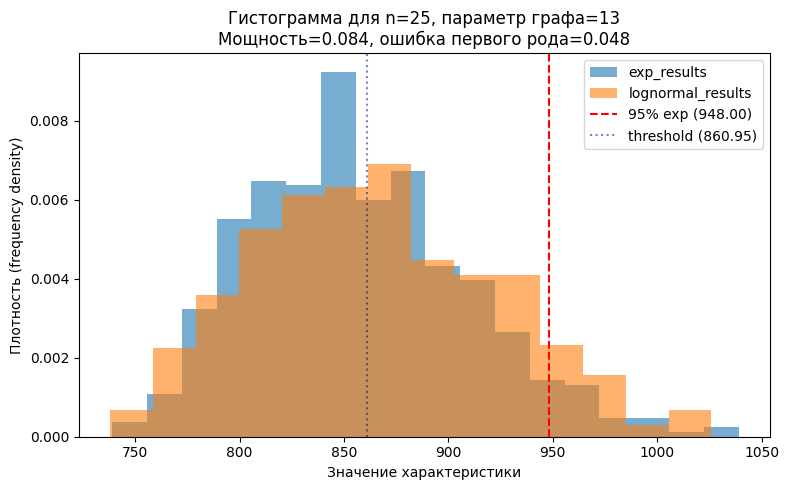

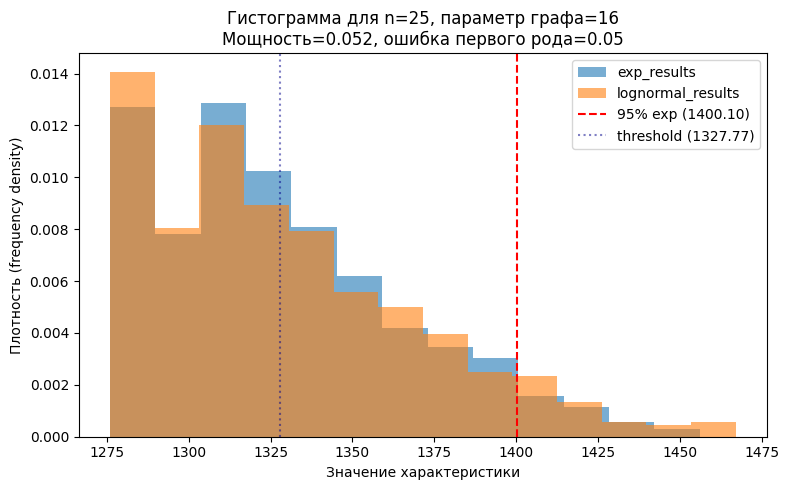

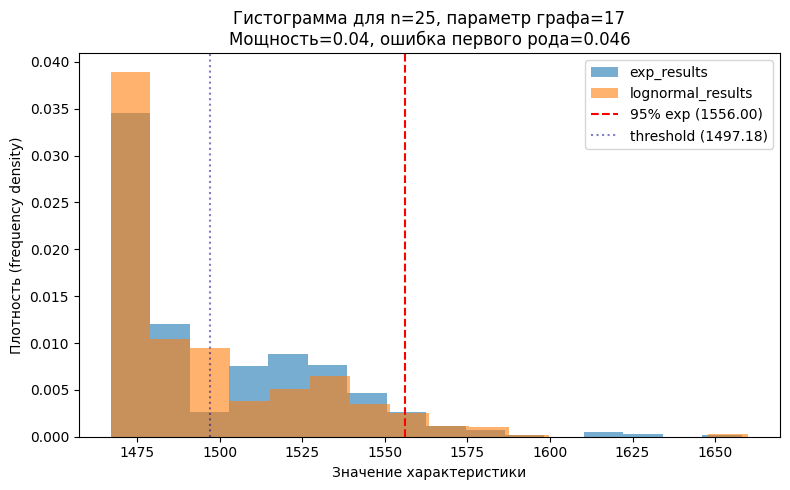

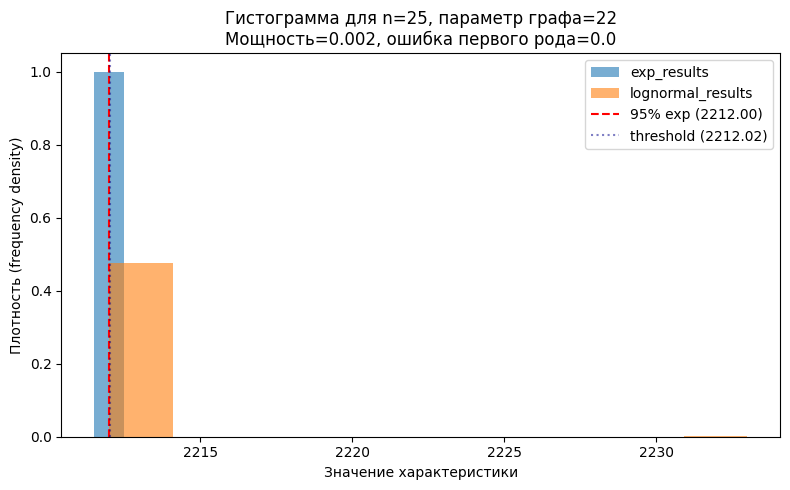

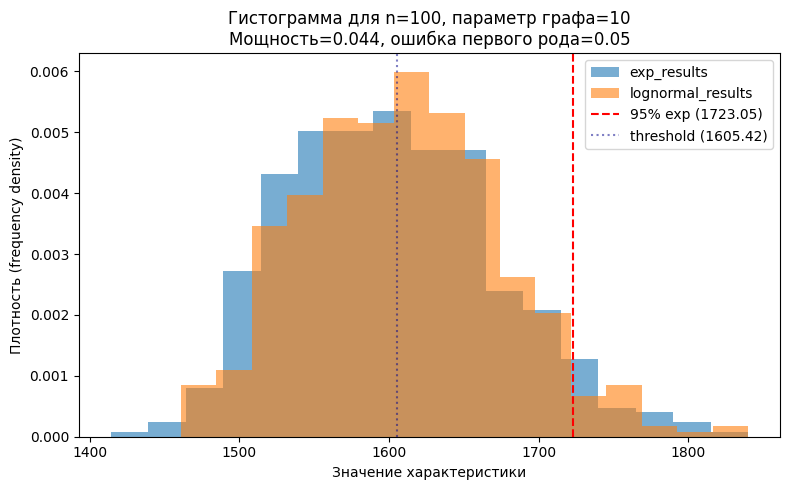

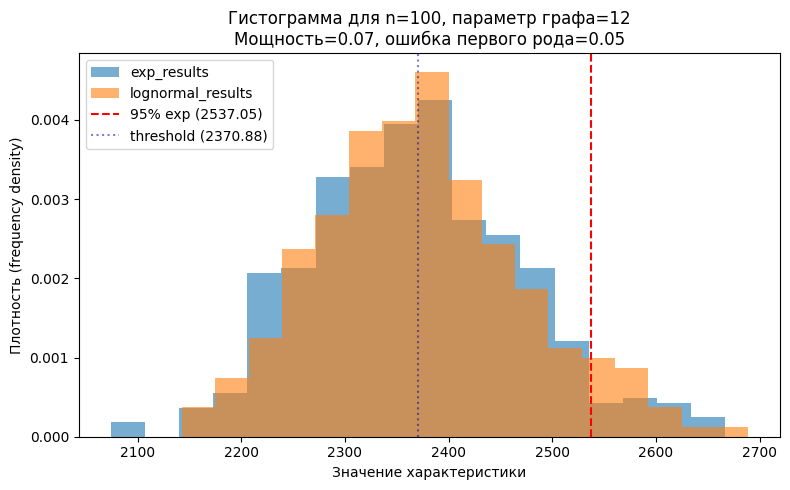

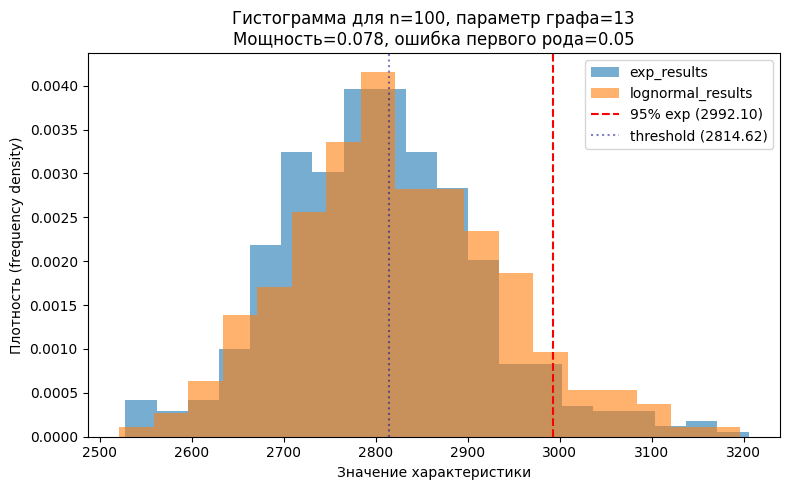

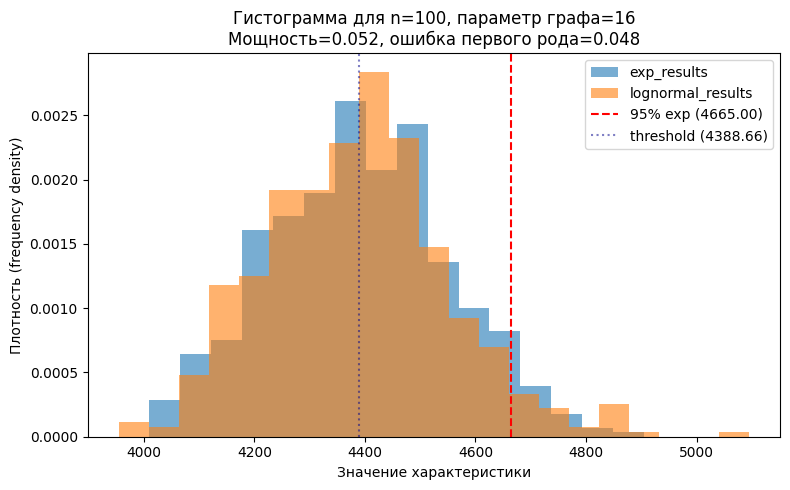

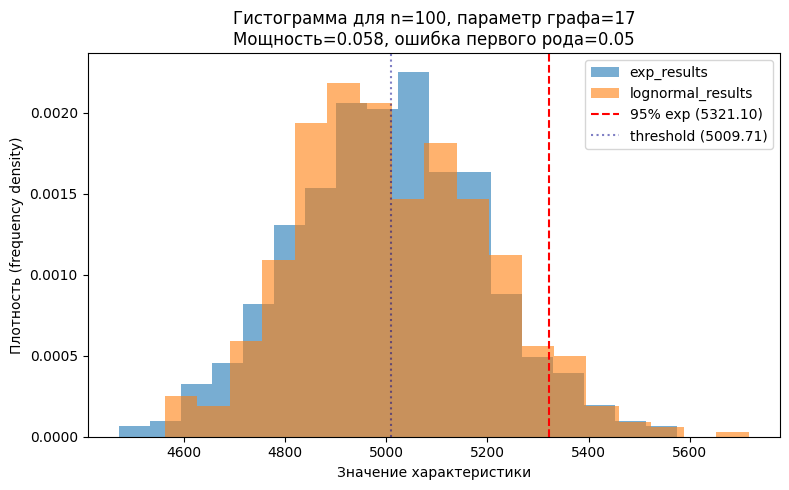

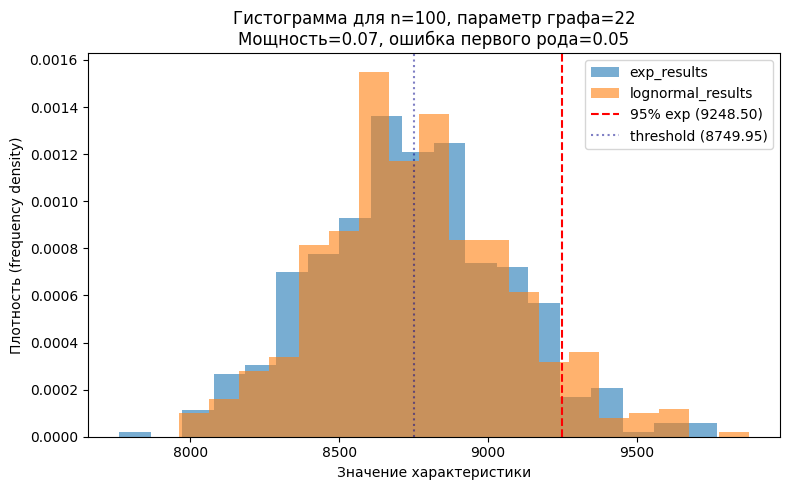

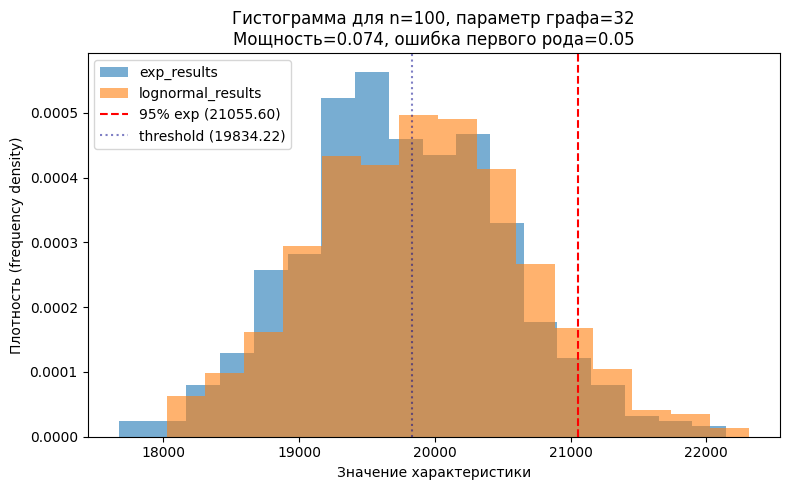

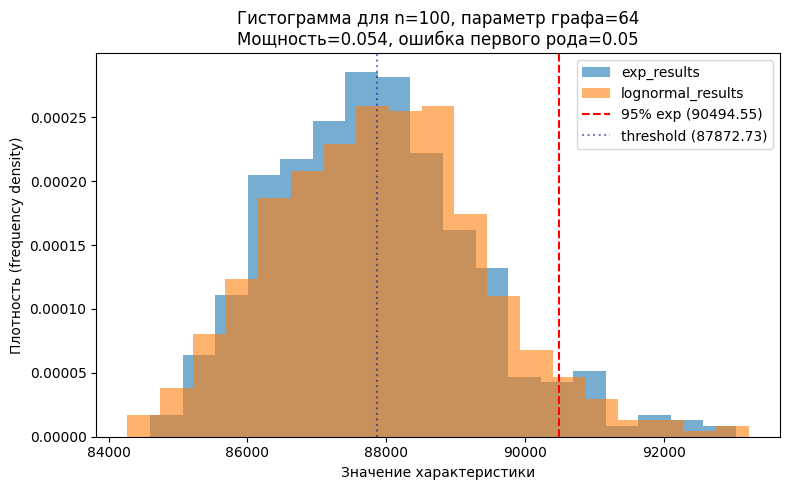

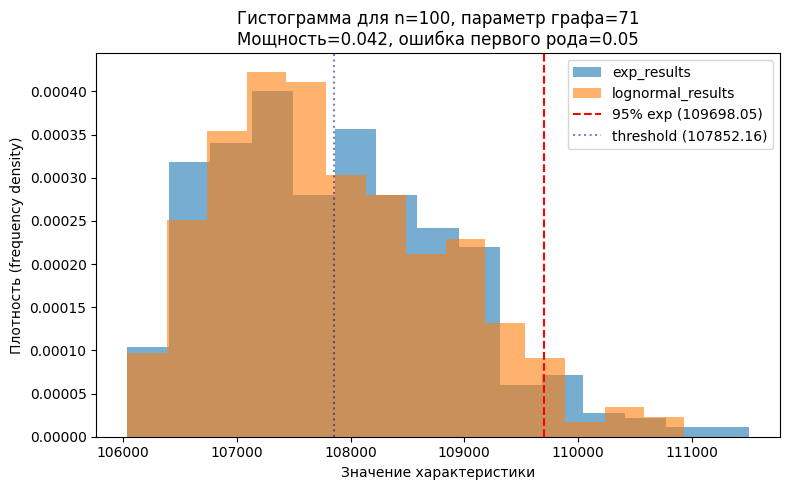

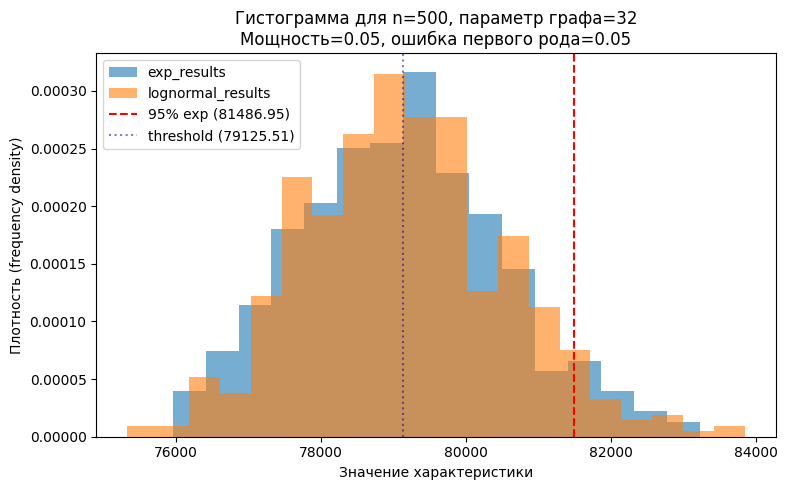

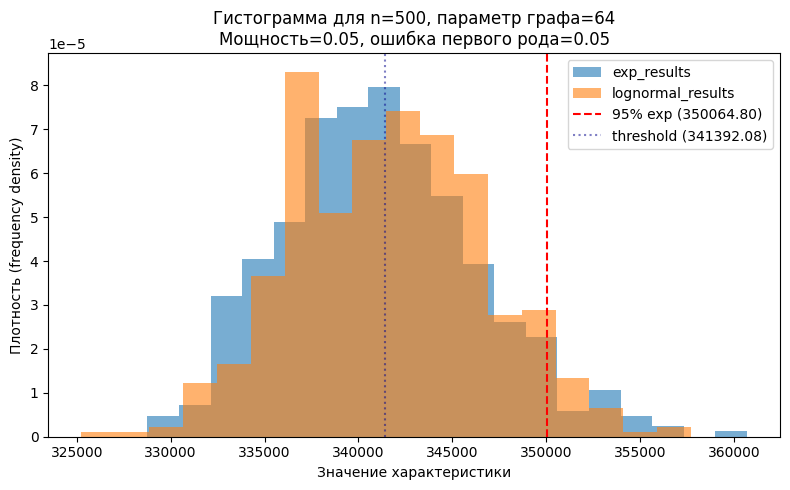

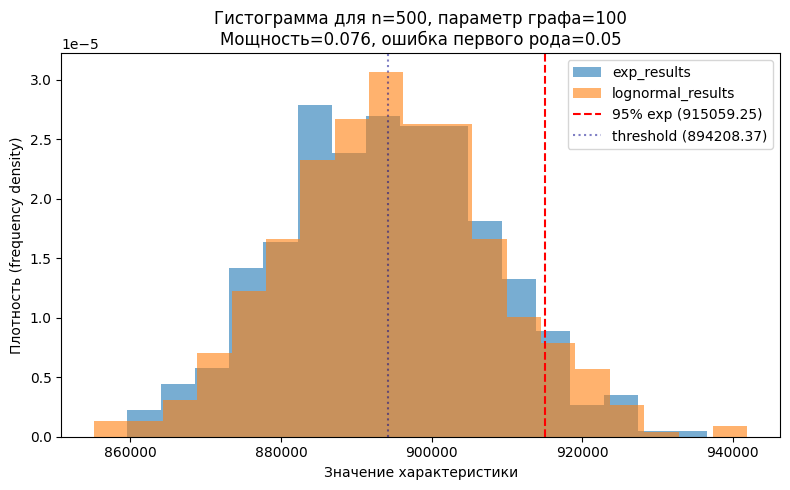

In [62]:
metrics_knn = []

for i, n in enumerate(n_array):
    for k in k_array[i]:
        if k >= n:
            continue
        normal_results = monte_carlo_multiprocessing(M, n, sigma0, k, generate_normal, build_knn_graph, count_triangles)
        skewnormal_results = monte_carlo_multiprocessing(M, n, alpha0, k, generate_skewnormal, build_knn_graph, count_triangles)
        metrics_knn.append(analyze(n, k, normal_results, skewnormal_results))

Выведем таблицу с основными статистическими метриками:

In [63]:
df_metrics = pd.DataFrame(metrics_knn)

In [64]:
df_metrics

n  graph_param  power  alpha    p95_exp   threshold    mean_exp  \
0    25            2  0.018  0.028      13.00      10.650      10.704   
1    25            4  0.038  0.050      72.05      61.480      61.698   
2    25            7  0.068  0.048     248.00     218.928     218.140   
3    25            8  0.054  0.050     340.05     296.879     295.762   
4    25            9  0.040  0.046     441.00     383.644     385.104   
5    25           10  0.038  0.046     552.00     481.532     482.004   
6    25           12  0.042  0.050     809.05     722.535     724.064   
7    25           13  0.084  0.048     948.00     860.951     856.798   
8    25           16  0.052  0.050    1400.10    1327.769    1327.532   
9    25           17  0.040  0.046    1556.00    1497.185    1498.774   
10   25           22  0.002  0.000    2212.00    2212.021    2212.000   
11  100           10  0.044  0.050    1723.05    1605.419    1601.374   
12  100           12  0.070  0.050    2537.05    2370.883    2367.320   
13  100           13  0.078  0.050    2992.10    2814.619    2805.696   
14  100           16  0.052  0.048    4665.00    4388.659    4390.062   
15  100           17  0.058  0.050    5321.10    5009.710    5006.348   
16  100           22  0.070  0.050    9248.50    8749.954    8741.138   
17  100           32  0.074  0.050   21055.60   19834.218   19770.328   
18  100           64  0.054  0.050   90494.55   87872.728   87832.980   
19  100           71  0.042  0.050  109698.05  107852.159  107862.152   
20  500           32  0.050  0.050   81486.95   79125.515   79107.712   
21  500           64  0.050  0.050  350064.80  341392.076  341171.542   
22  500          100  0.076  0.050  915059.25  894208.369  893915.478   

         var_exp       std_exp      se_exp    mean_log       var_log  \
0   2.284954e+00      1.511606    0.067601      10.596  2.425635e+00   
1   3.738156e+01      6.114046    0.273428      61.262  3.332801e+01   
2   3.354553e+02     18.315439    0.819091     219.716  3.530334e+02   
3   6.737288e+02     25.956287    1.160800     297.996  5.922886e+02   
4   1.039103e+03     32.235127    1.441599     382.184  9.650683e+02   
5   1.507651e+03     38.828486    1.736463     481.060  1.419107e+03   
6   2.589539e+03     50.887513    2.275759     721.006  2.660623e+03   
7   2.653015e+03     51.507429    2.303482     865.104  3.396414e+03   
8   1.471015e+03     38.353813    1.715235    1328.006  1.663084e+03   
9   1.028560e+03     32.071172    1.434266    1495.596  9.572793e+02   
10  0.000000e+00      0.000000    0.000000    2212.042  8.820000e-01   
11  4.839862e+03     69.569116    3.111225    1609.464  4.319195e+03   
12  1.028917e+04    101.435536    4.536335    2374.446  9.788284e+03   
13  1.183551e+04    108.791133    4.865287    2823.542  1.317513e+04   
14  2.629572e+04    162.159544    7.251995    4387.256  2.721805e+04   
15  3.419567e+04    184.920703    8.269905    5013.072  3.469049e+04   
16  1.027366e+05    320.525475   14.334335    8758.770  1.002666e+05   
17  5.608480e+05    748.897836   33.491729   19898.108  6.119941e+05   
18  2.126466e+06   1458.240669   65.214505   87912.476  2.248502e+06   
19  1.043208e+06   1021.375369   45.677295  107842.166  9.816245e+05   
20  1.927260e+06   1388.257834   62.084778   79143.318  1.936343e+06   
21  2.659253e+07   5156.794546  230.618863  341612.610  2.570227e+07   
22  1.843565e+08  13577.793403  607.217381  894501.260  1.884472e+08   

         std_log      se_log  
0       1.557445    0.069651  
1       5.773042    0.258178  
2      18.789183    0.840278  
3      24.336979    1.088383  
4      31.065548    1.389294  
5      37.671031    1.684700  
6      51.581229    2.306783  
7      58.278761    2.606305  
8      40.780929    1.823779  
9      30.939931    1.383676  
10      0.939149    0.042000  
11     65.720583    2.939114  
12     98.935755    4.424541  
13    114.782989    5.133251  
14    164.978940    7.378082  
15    186.253837    8.329525

**Вывод:**\
Мощность, в отличие от случая с кликовым числом, почти не коррелирует, `p95_exp` и `threshold` растут. Аналогично возьмём $k = \frac{2}{3}n$.

Я думаю, что для данной задачи лучше подходит дистанционный граф, в дальнейшем буду использовать его.

## Исследуем, как ведет себя $Τ$ в зависимости от параметров распределения

In [65]:
def analyze_sigma_alpha(sigma, alpha_, exp_results, lognormal_results, need_hist=True):
    mean_exp, var_exp, std_exp, se_exp = compute_stats(exp_results)
    mean_log, var_log, std_log, se_log = compute_stats(lognormal_results)
    p95_exp = np.percentile(exp_results, 95)
    threshold = (mean_exp + mean_log) / 2

    alpha = np.mean(exp_results > p95_exp)
    power = np.mean(lognormal_results > p95_exp)


    metrics = {
        'sigma': sigma, 'alpha_param': alpha_,
        'power': power,
        'alpha': alpha,
        'p95_exp': p95_exp,
        'threshold': threshold,
        'mean_norm': mean_exp, 'var_norm': var_exp, 'std_norm': std_exp, 'se_norm': se_exp,
        'mean_skewnorm': mean_log, 'var_skewnorm': var_log, 'std_skewnorm': std_log, 'se_skewnorm': se_log,
    }

    if not need_hist:
        return metrics

    fig, ax = plt.subplots(figsize=(8, 5))
    bins = 'auto'

    ax.hist(exp_results, bins=bins, alpha=0.6, label='norm_results', density=True)
    ax.hist(lognormal_results, bins=bins, alpha=0.6, label='skewnorm_results', density=True)

    ax.axvline(p95_exp, color='red', linestyle='--',
                label=f'95% exp ({p95_exp:.2f})')
    
    ax.axvline(threshold, color='darkblue', alpha=0.5, linestyle=':',
                label=f'threshold ({threshold:.2f})')

    ax.set_title(f'Гистограмма для sigma={sigma}, alpha={alpha_}\nМощность={power}, ошибка первого рода={alpha}')
    ax.set_xlabel('Значение характеристики')
    ax.set_ylabel('Плотность (frequency density)')
    ax.legend()
    plt.tight_layout()
    plt.show()

    return metrics

#### Исследуем KNN-граф

In [ ]:
n = 100
k = int(2 * n / 3)

In [67]:
sigma_array = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
alpha_array = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0]

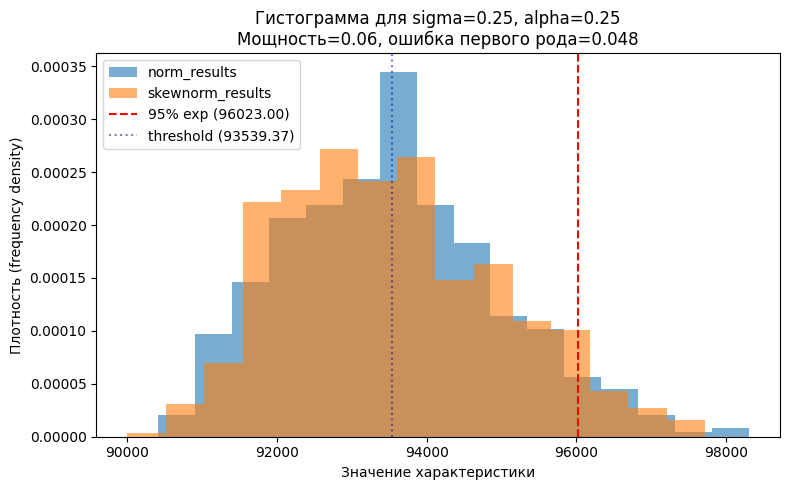

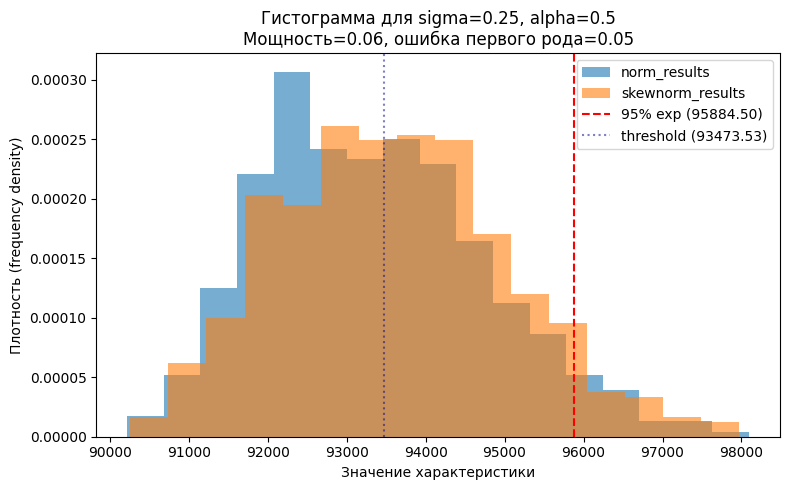

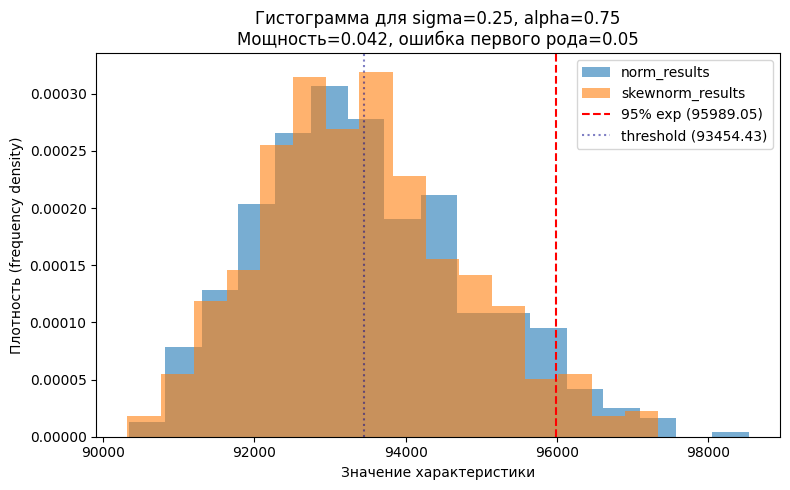

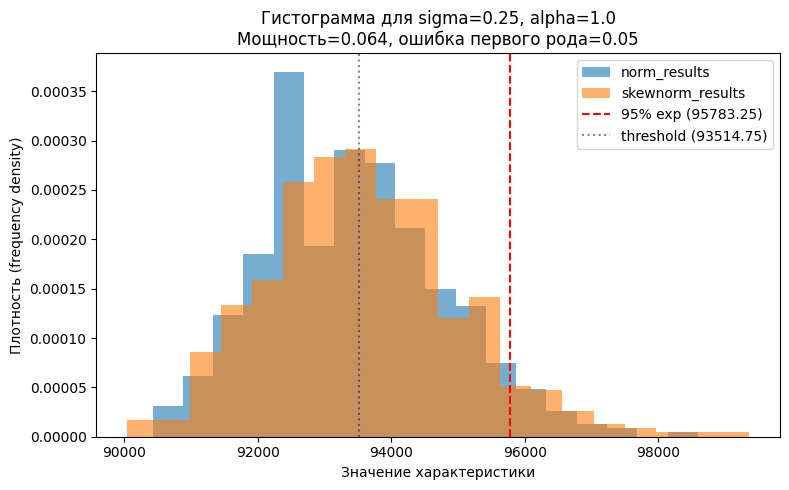

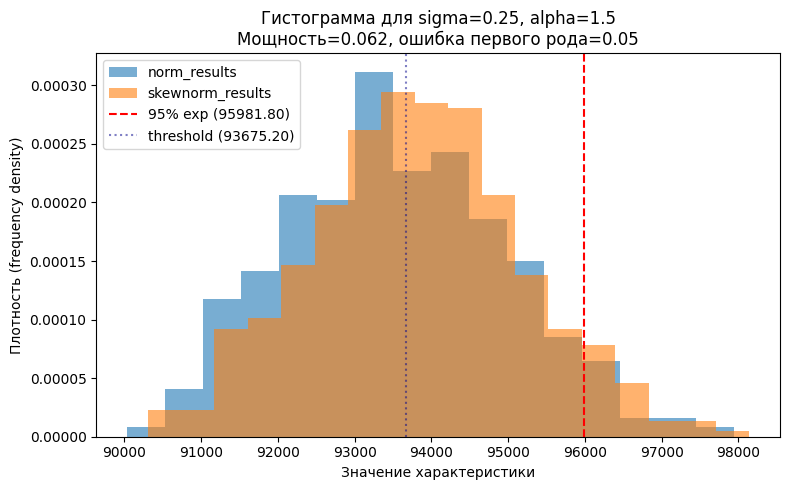

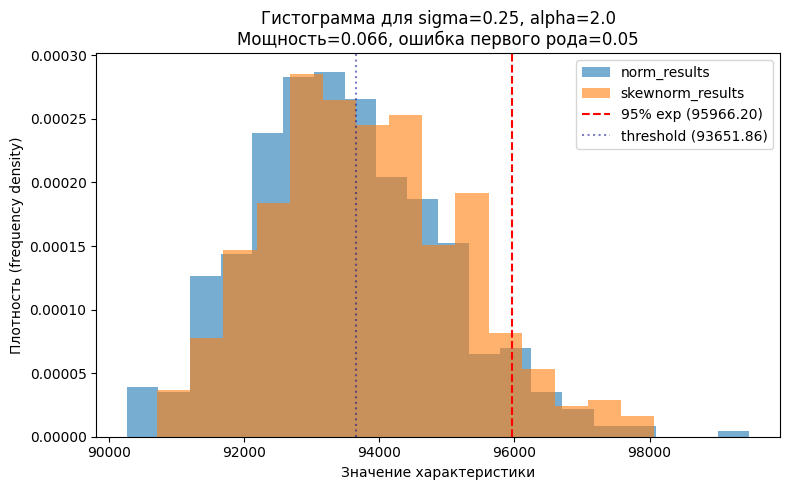

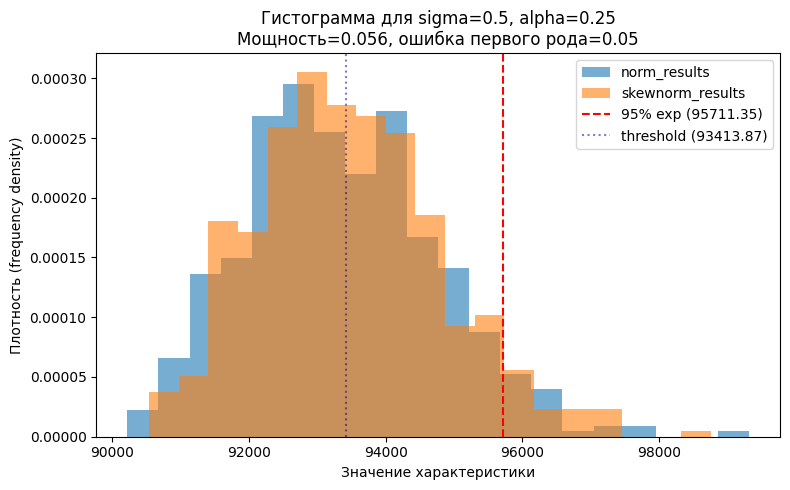

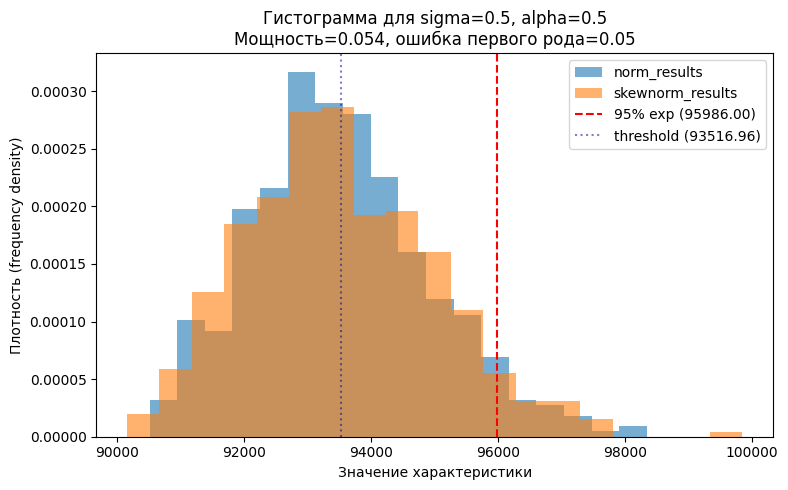

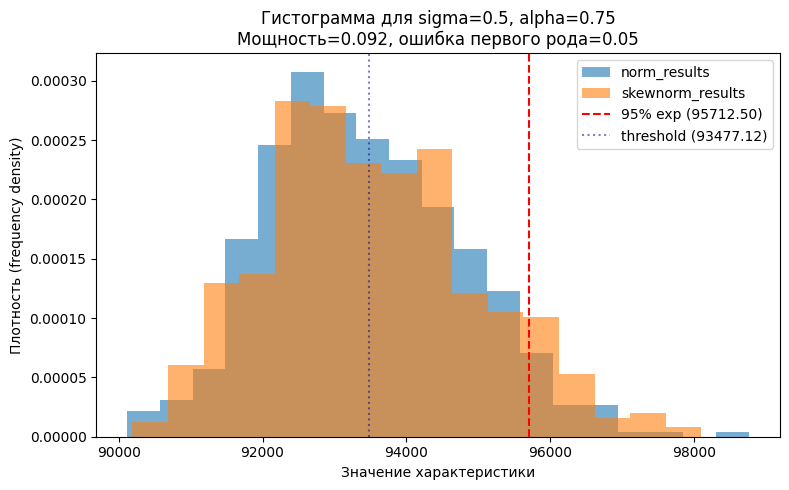

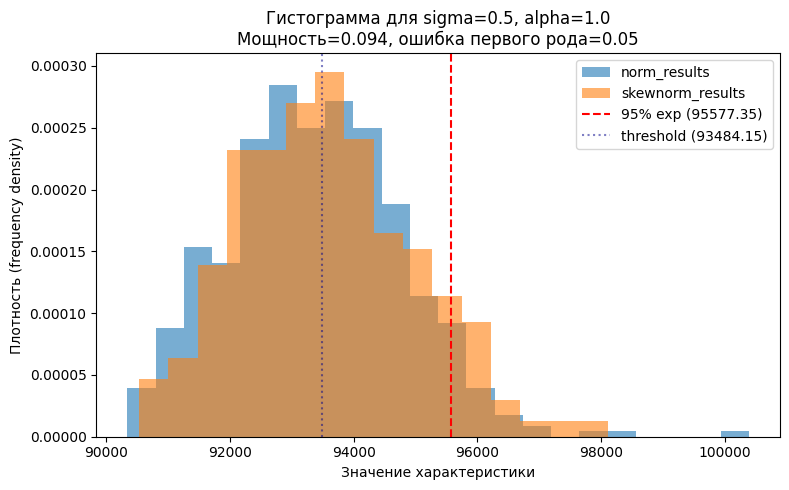

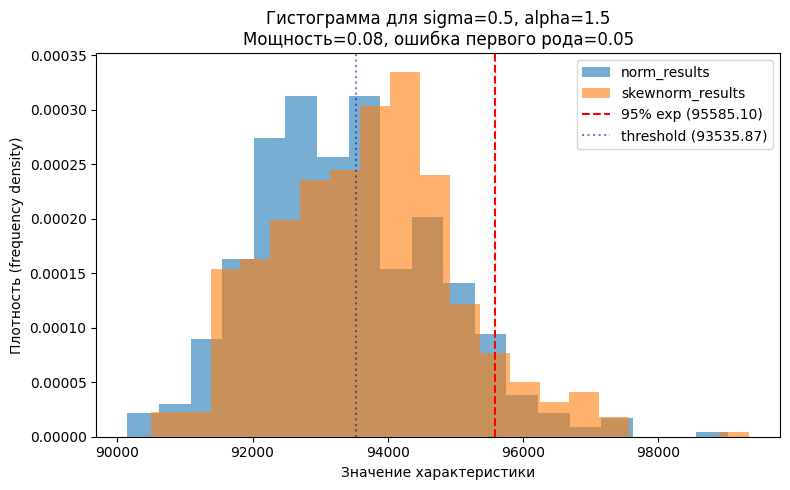

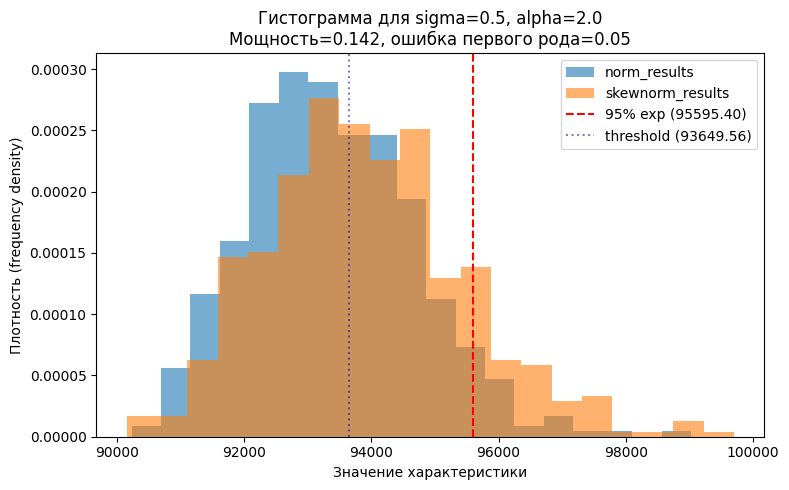

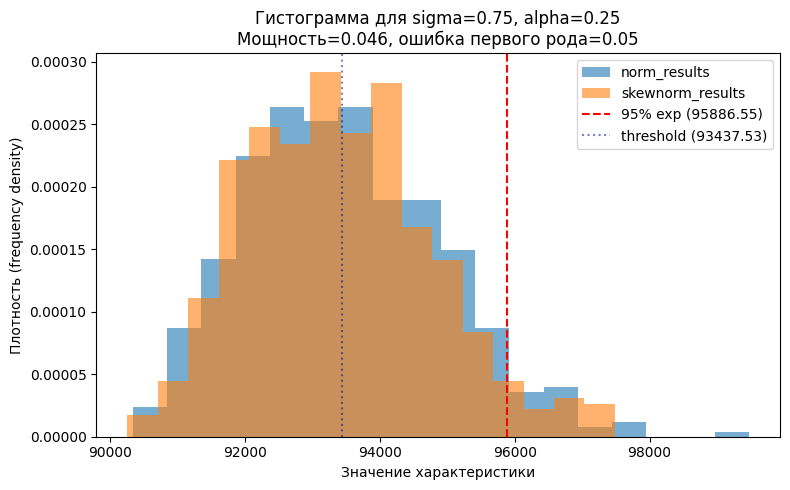

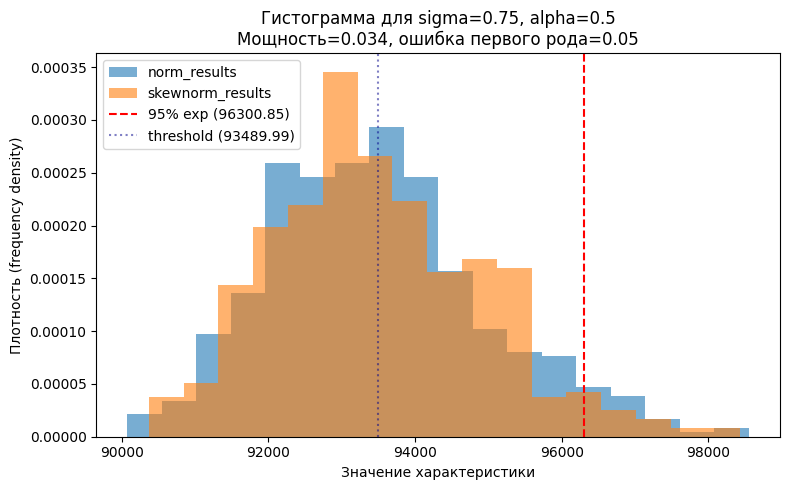

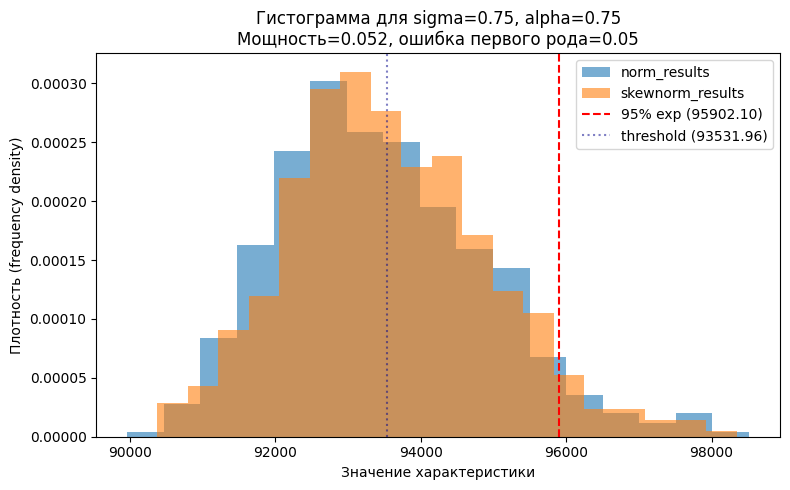

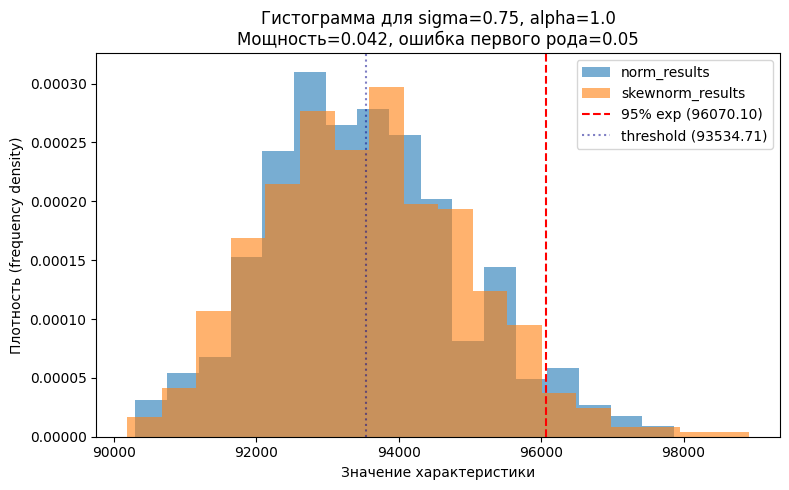

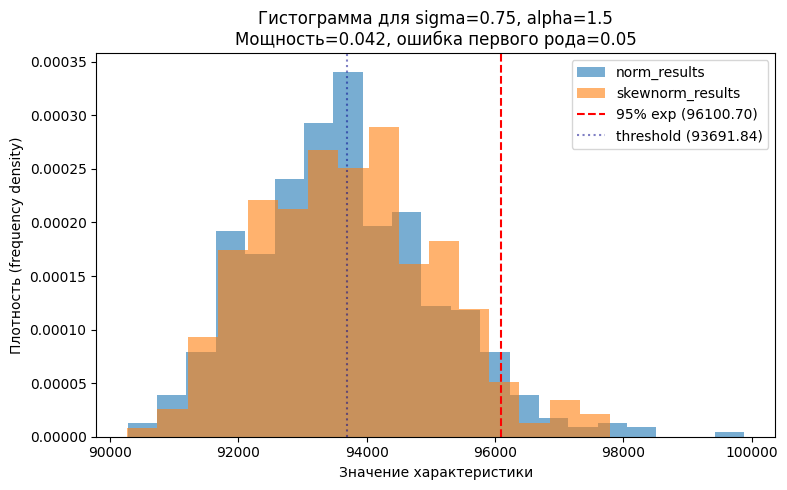

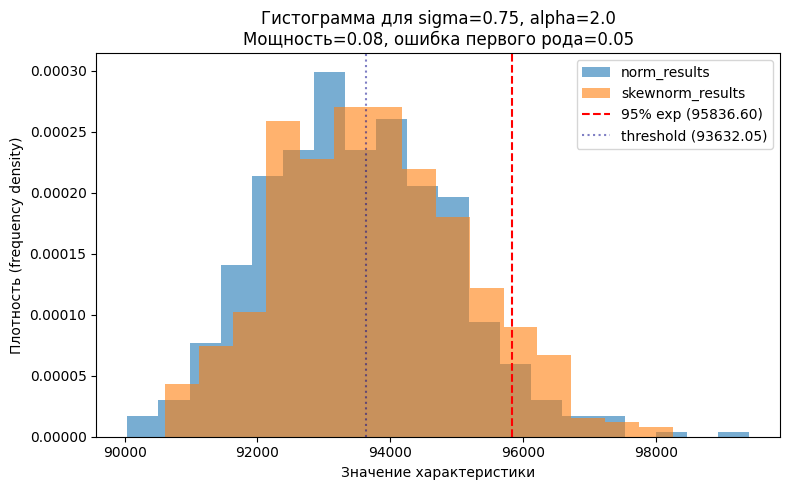

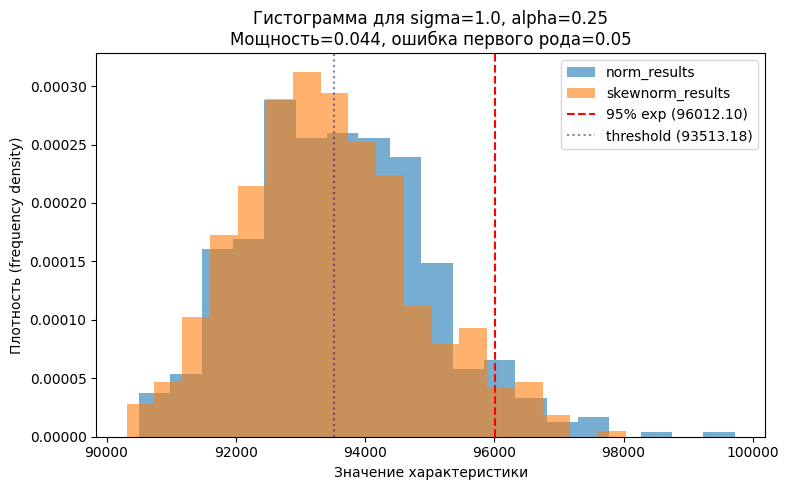

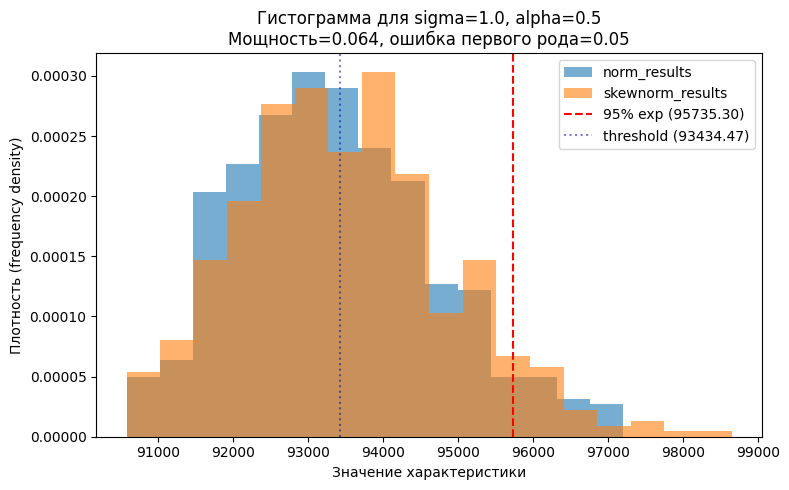

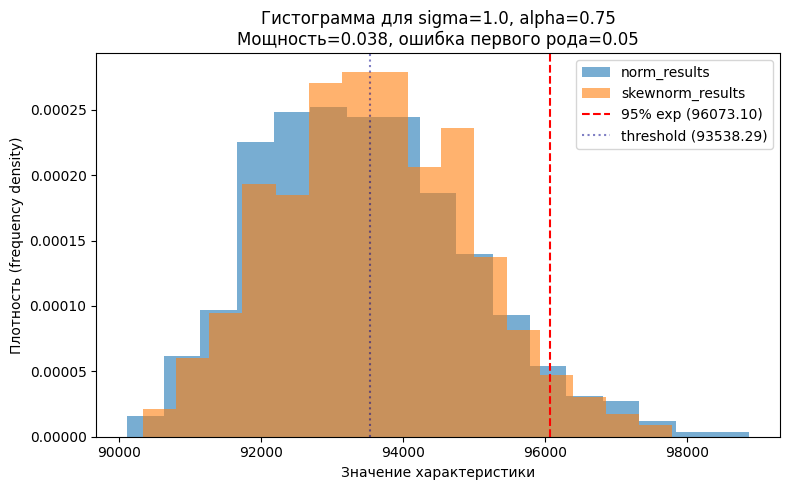

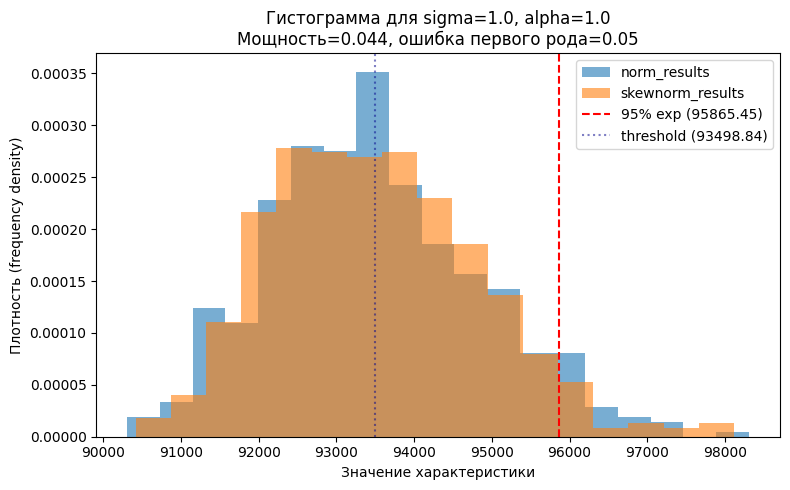

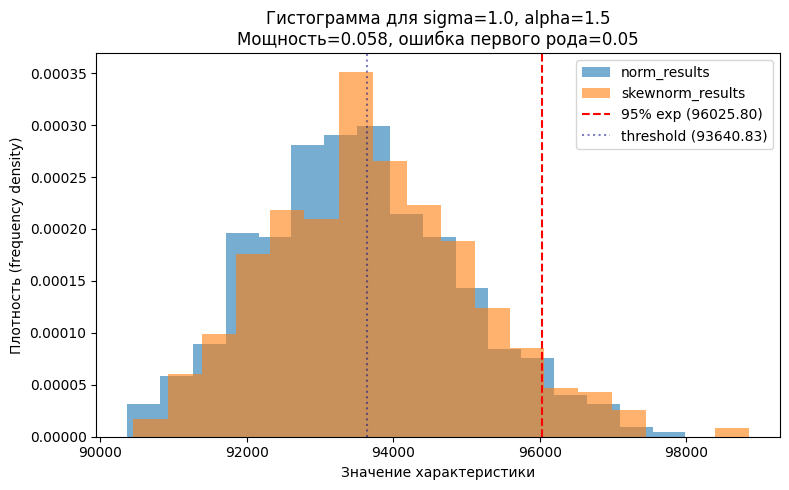

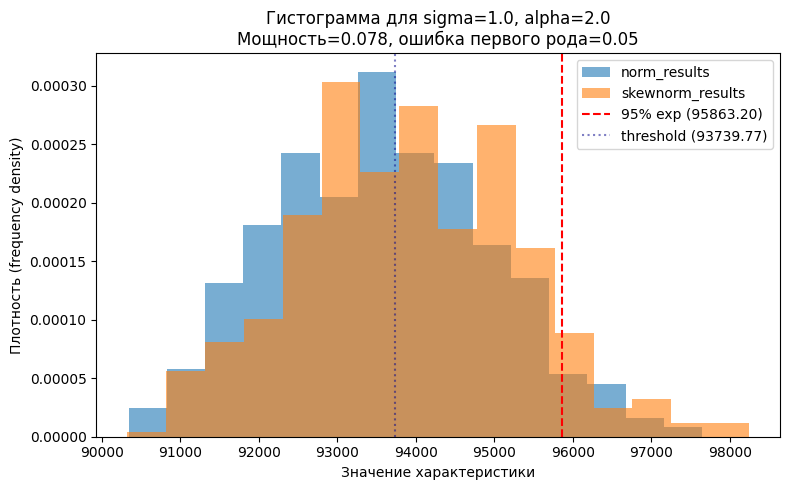

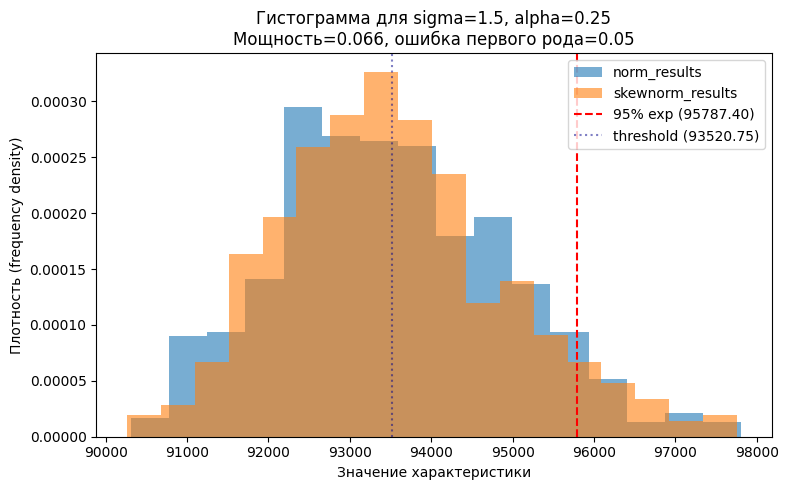

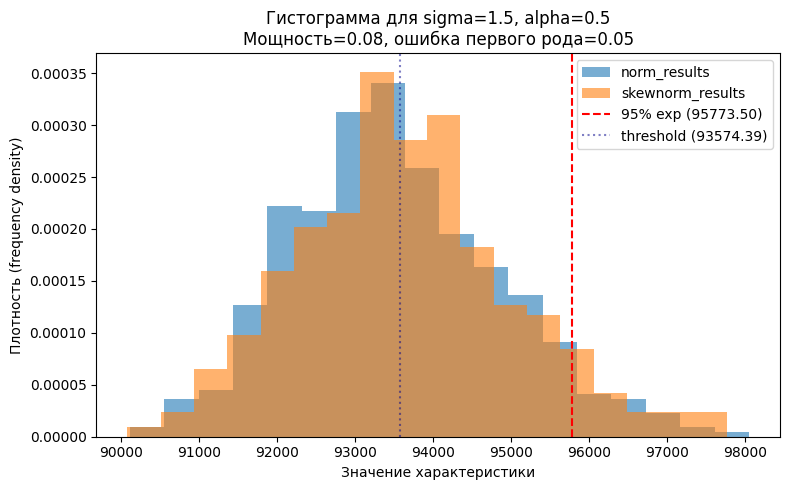

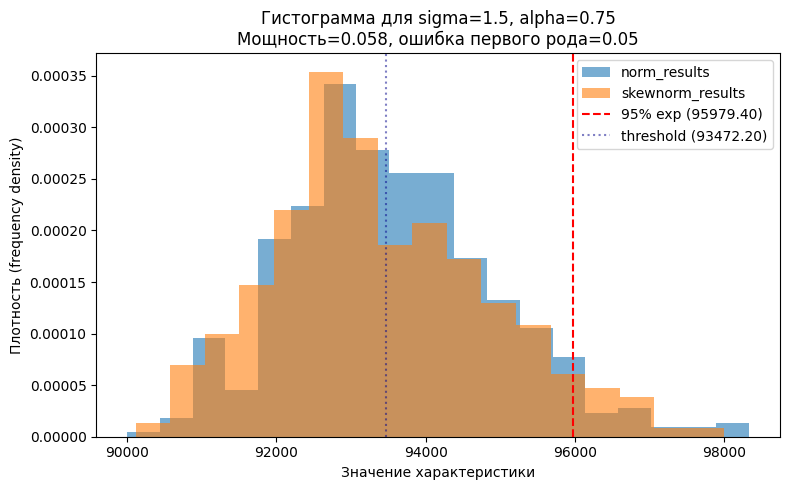

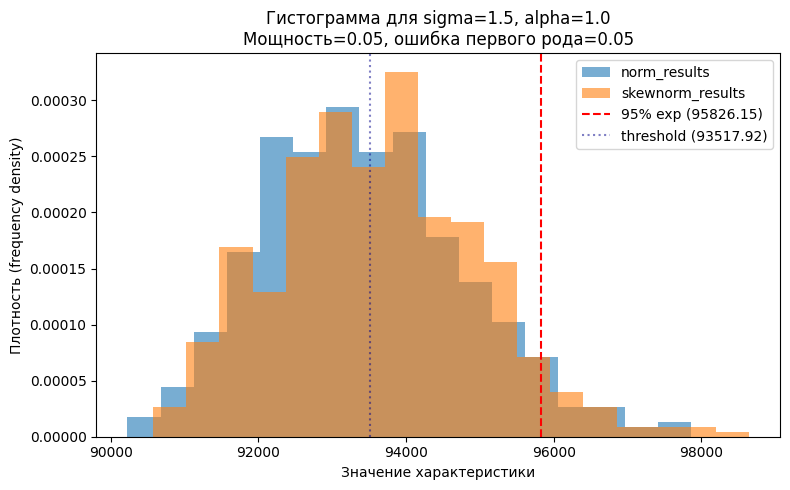

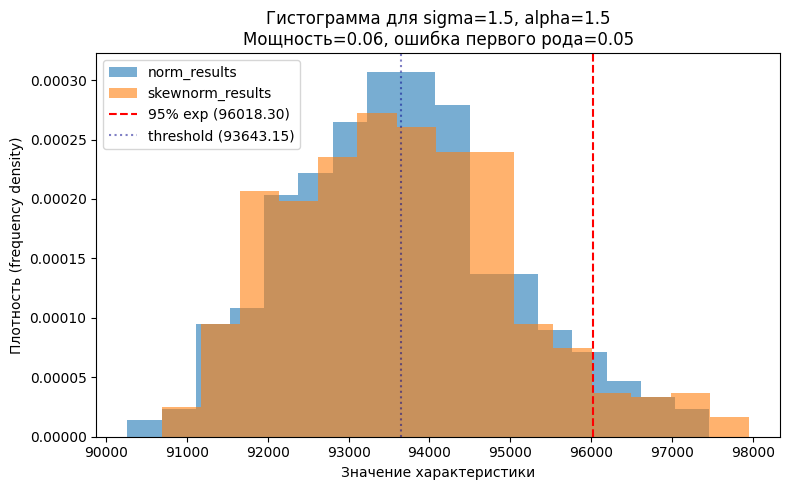

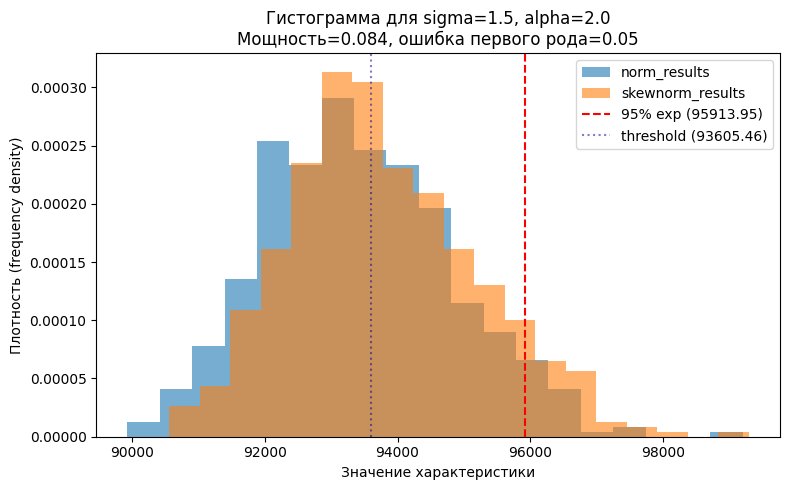

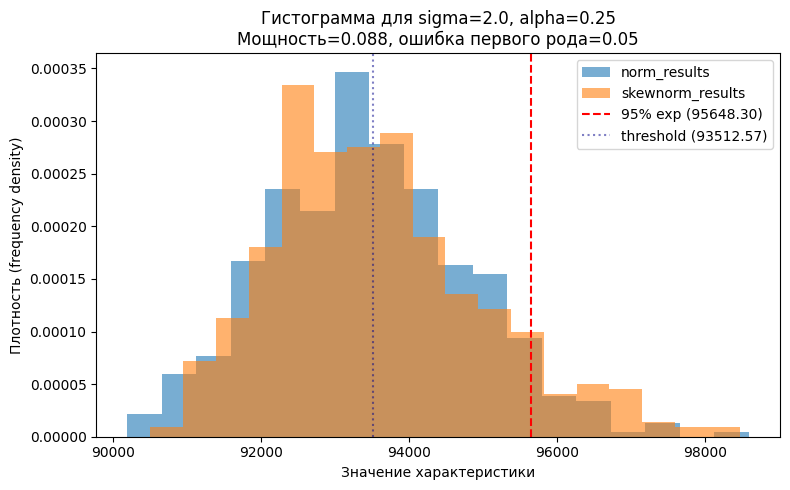

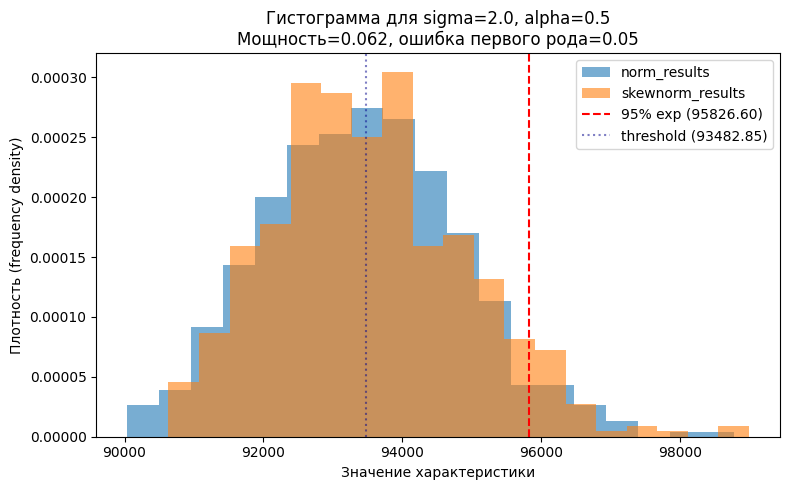

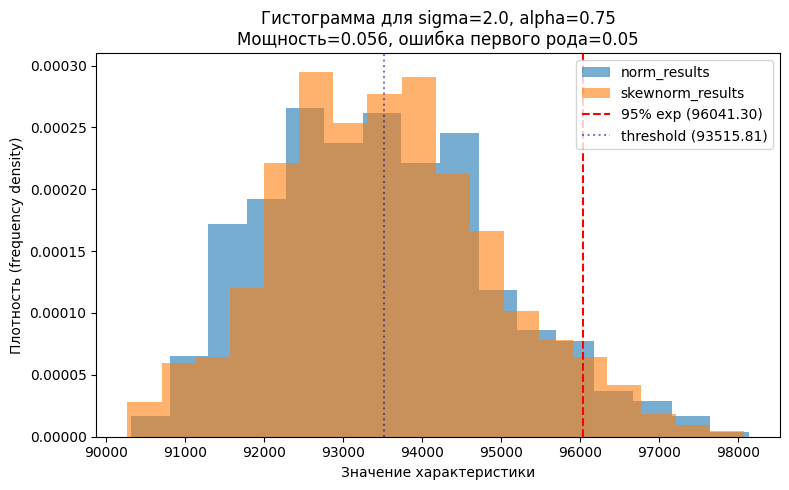

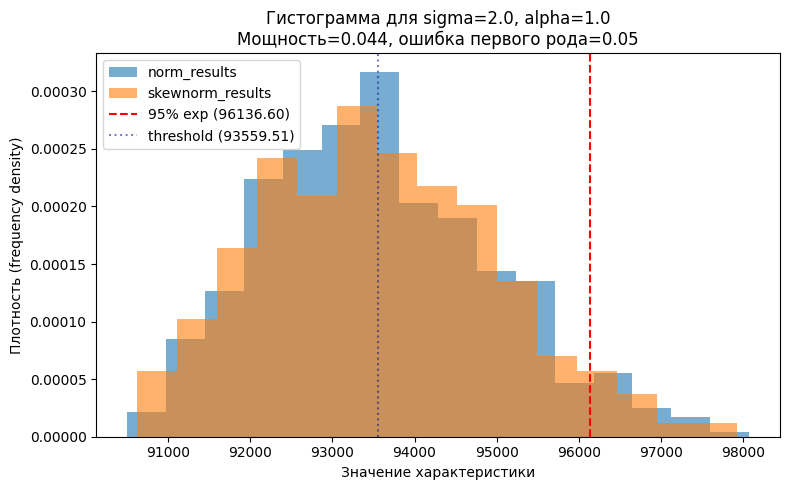

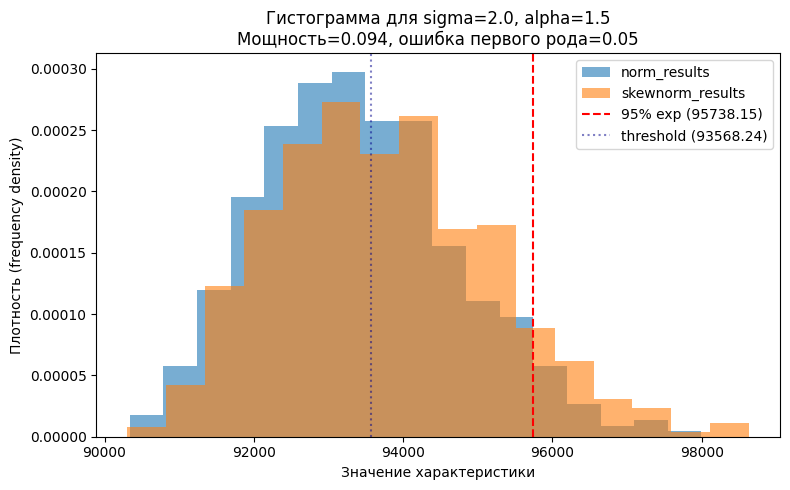

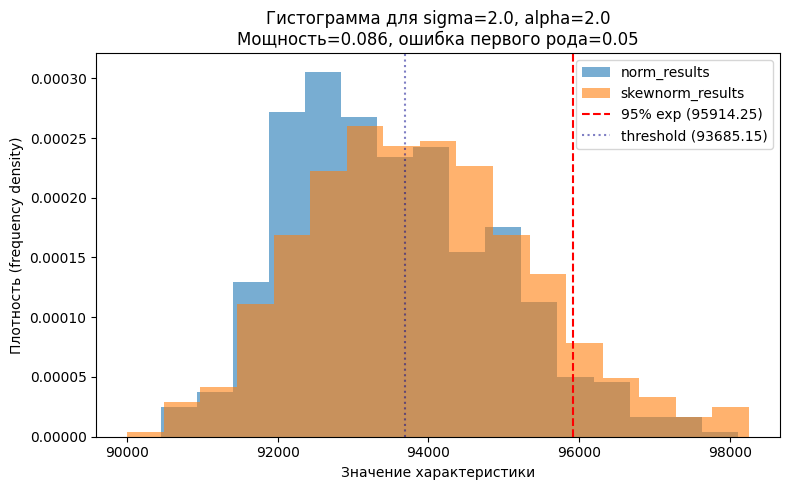

In [68]:
metrics_knn = []

for sigma in sigma_array:
    for alpha in alpha_array:
        normal_results = monte_carlo_multiprocessing(M, n, sigma, k, generate_normal, build_knn_graph, count_triangles)
        skewnormal_results = monte_carlo_multiprocessing(M, n, alpha, k, generate_skewnormal, build_knn_graph, count_triangles)
        metrics_knn.append(analyze_sigma_alpha(sigma, alpha, normal_results, skewnormal_results))

df_metrics = pd.DataFrame(metrics_knn)

In [69]:
df_metrics

sigma  alpha_param  power  alpha   p95_exp  threshold  mean_norm  \
0    0.25         0.25  0.060  0.048  96023.00  93539.367  93538.796   
1    0.25         0.50  0.060  0.050  95884.50  93473.527  93348.182   
2    0.25         0.75  0.042  0.050  95989.05  93454.435  93483.044   
3    0.25         1.00  0.064  0.050  95783.25  93514.752  93427.410   
4    0.25         1.50  0.062  0.050  95981.80  93675.204  93551.714   
5    0.25         2.00  0.066  0.050  95966.20  93651.855  93496.356   
6    0.50         0.25  0.056  0.050  95711.35  93413.867  93357.418   
7    0.50         0.50  0.054  0.050  95986.00  93516.963  93511.062   
8    0.50         0.75  0.092  0.050  95712.50  93477.122  93420.460   
9    0.50         1.00  0.094  0.050  95577.35  93484.147  93390.138   
10   0.50         1.50  0.080  0.050  95585.10  93535.873  93384.290   
11   0.50         2.00  0.142  0.050  95595.40  93649.559  93381.800   
12   0.75         0.25  0.046  0.050  95886.55  93437.531  93468.816   
13   0.75         0.50  0.034  0.050  96300.85  93489.995  93489.172   
14   0.75         0.75  0.052  0.050  95902.10  93531.960  93481.104   
15   0.75         1.00  0.042  0.050  96070.10  93534.705  93510.694   
16   0.75         1.50  0.042  0.050  96100.70  93691.837  93664.802   
17   0.75         2.00  0.080  0.050  95836.60  93632.046  93512.040   
18   1.00         0.25  0.044  0.050  96012.10  93513.178  93606.634   
19   1.00         0.50  0.064  0.050  95735.30  93434.468  93369.226   
20   1.00         0.75  0.038  0.050  96073.10  93538.291  93479.384   
21   1.00         1.00  0.044  0.050  95865.45  93498.839  93489.758   
22   1.00         1.50  0.058  0.050  96025.80  93640.826  93552.790   
23   1.00         2.00  0.078  0.050  95863.20  93739.766  93570.954   
24   1.50         0.25  0.066  0.050  95787.40  93520.751  93518.994   
25   1.50         0.50  0.080  0.050  95773.50  93574.385  93516.208   
26   1.50         0.75  0.058  0.050  95979.40  93472.203  93550.108   
27   1.50         1.00  0.050  0.050  95826.15  93517.922  93439.962   
28   1.50         1.50  0.060  0.050  96018.30  93643.154  93618.124   
29   1.50         2.00  0.084  0.050  95913.95  93605.455  93418.708   
30   2.00         0.25  0.088  0.050  95648.30  93512.571  93456.794   
31   2.00         0.50  0.062  0.050  95826.60  93482.851  93431.328   
32   2.00         0.75  0.056  0.050  96041.30  93515.806  93475.978   
33   2.00         1.00  0.044  0.050  96136.60  93559.506  93567.324   
34   2.00         1.50  0.094  0.050  95738.15  93568.242  93393.710   
35   2.00         2.00  0.086  0.050  95914.25  93685.152  93512.608   

        var_norm     std_norm    se_norm  mean_skewnorm  var_skewnorm  \
0   2.022670e+06  1422.206006  63.602986      93539.938  2.114226e+06   
1   1.944939e+06  1394.610799  62.368891      93598.872  2.055699e+06   
2   2.015608e+06  1419.721090  63.491857      93425.826  1.772539e+06   
3   1.833306e+06  1353.996201  60.552551      93602.094  2.028083e+06   
4   2.030885e+06  1425.091244  63.732018      93798.694  1.865825e+06   
5   2.019326e+06  1421.030043  63.550395      93807.354  2.023578e+06   
6   1.908403e+06  1381.449442  61.780297      93470.316  1.791192e+06   
7   1.952654e+06  1397.374061  62.492468      93522.864  2.211184e+06   
8   1.810310e+06  1345.477745  60.171594      93533.784  2.160320e+06   
9   1.917534e+06  1384.750548  61.927927      93578.156  1.984613e+06   
10  1.795550e+06  1339.981414  59.925791      93687.456  1.806907e+06   
11  1.746182e+06  1321.431811  59.096227      93917.318  2.421869e+06   
12  2.106868e+06  1451.505528  64.913301      93406.246  1.885893e+06   
13  2.211881e+06  1487.239428  66.511369      93490.818  2.019231e+06   
14  2.026586e+06  1423.581943  63.664520      93582.816  1.890610e+06   
15  1.906597e+06  1380.795770  61.751064      93558.716  1.971347e+06   
16  2.049267e+06  1431.526071  64.019792      93718.872  1.942239e+06   
17  1.963683e+06  1401.31

**Вывод:**\
Мощность больше зависит от $\alpha$, чем от $\sigma$. Ошибка первого рода почти везде одинаковая. Изменения незначительны также для `p95_exp` и `threshold`.

#### Исследуем дистанционный-граф

In [ ]:
n = 100
d = 0.9

In [74]:
sigma_array = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
alpha_array = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0]

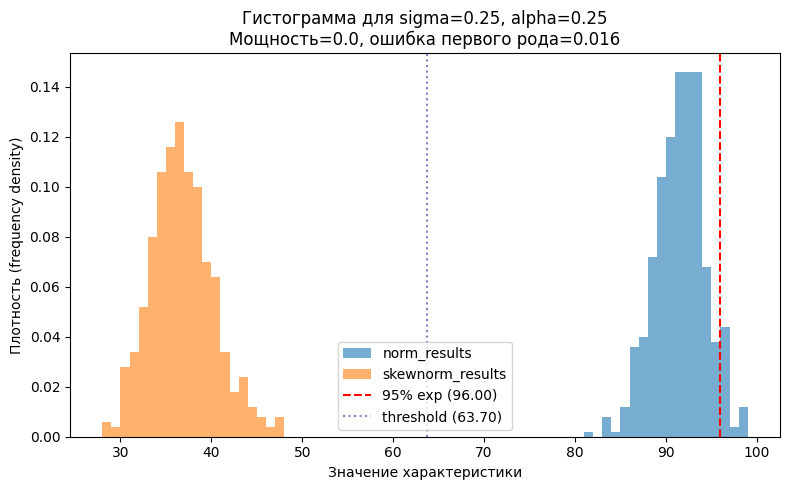

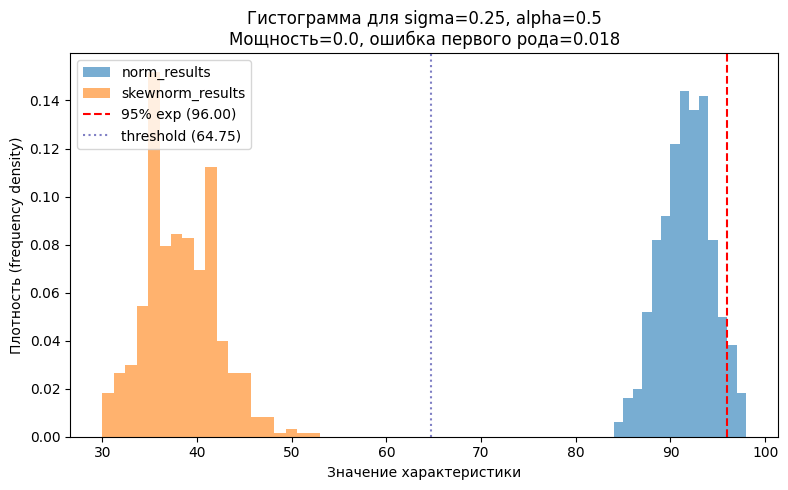

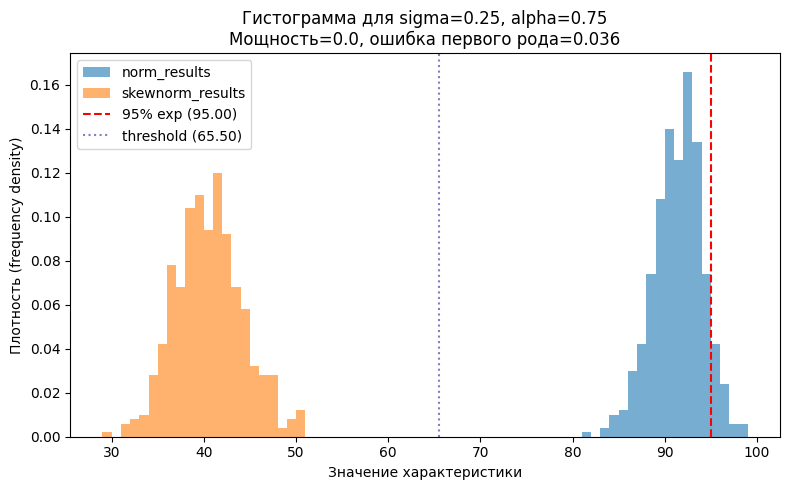

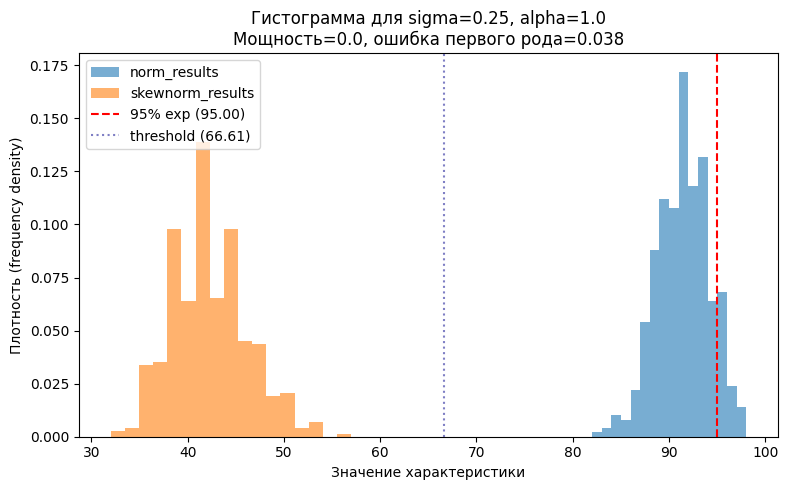

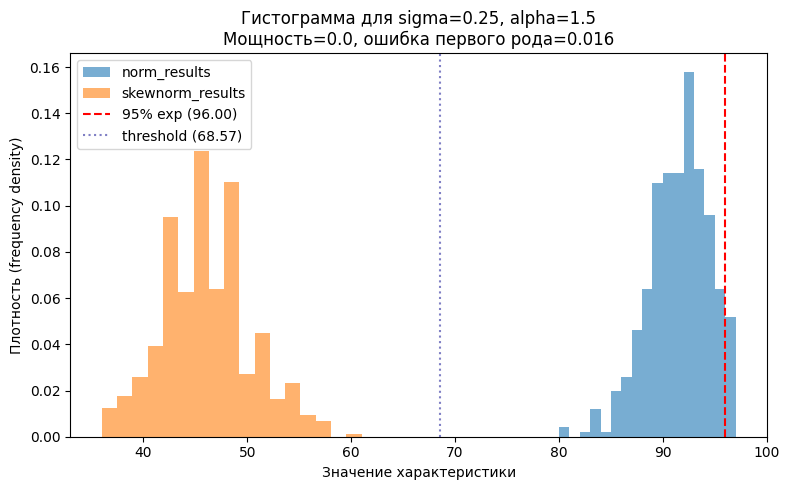

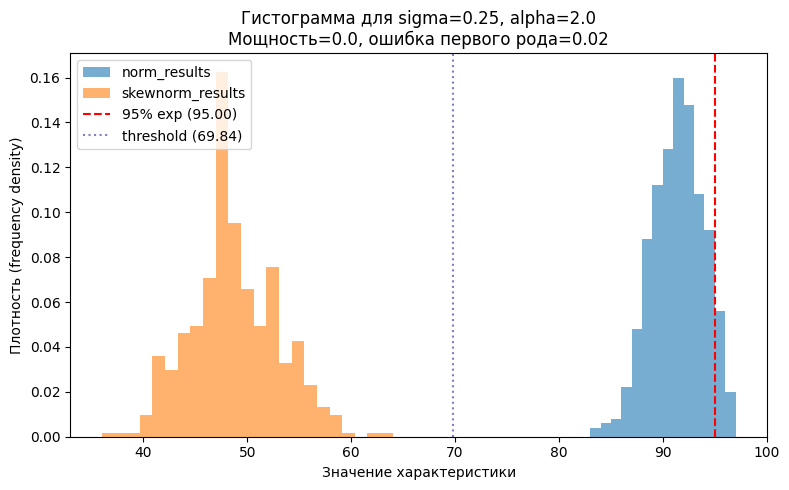

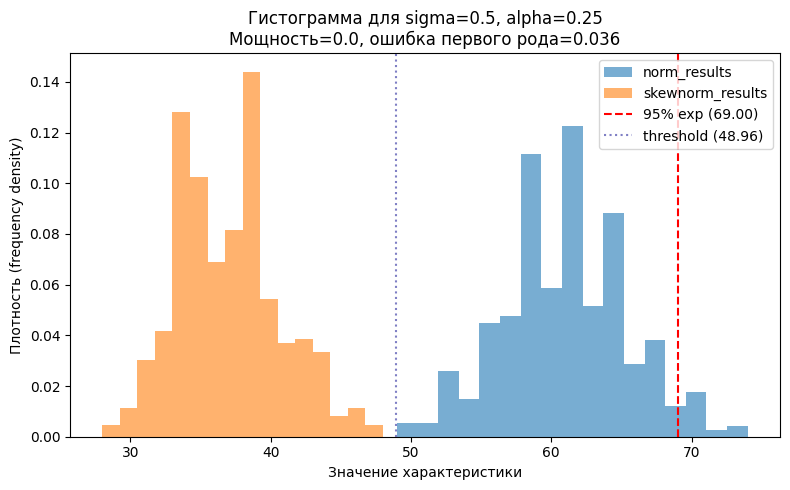

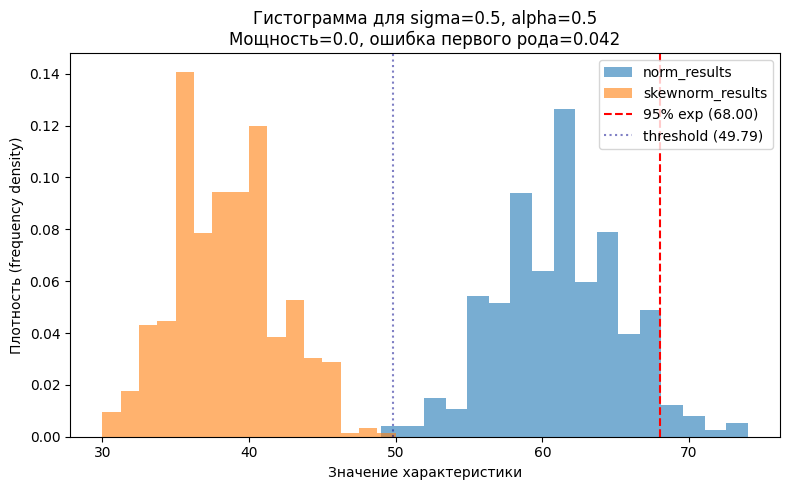

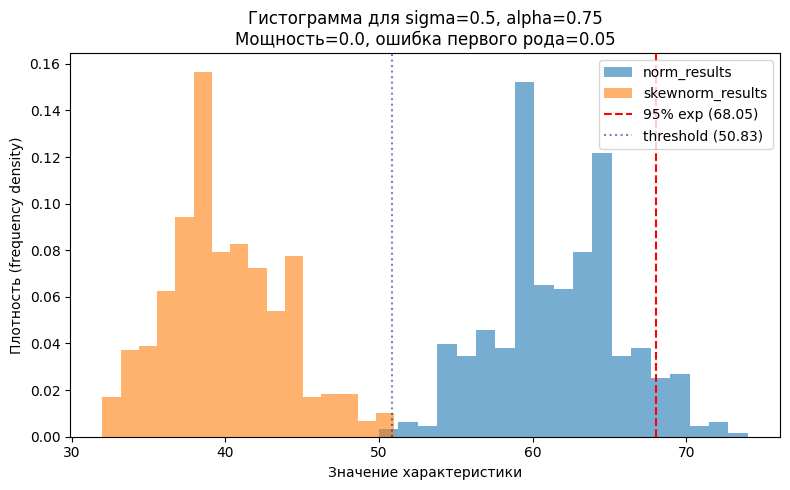

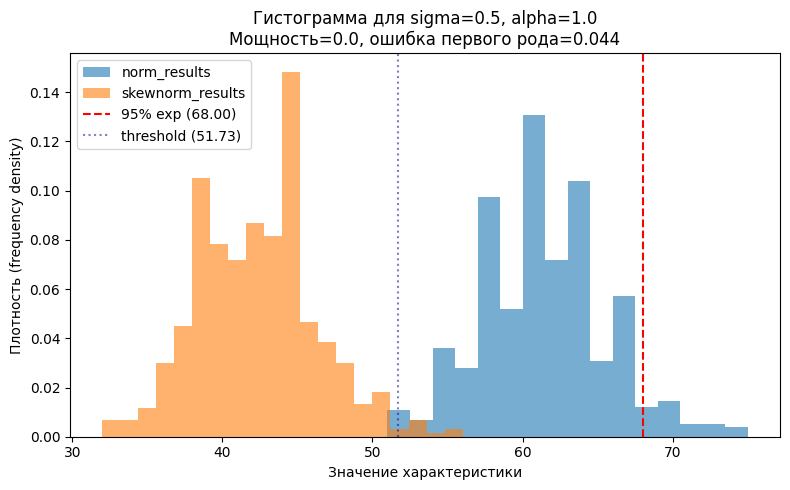

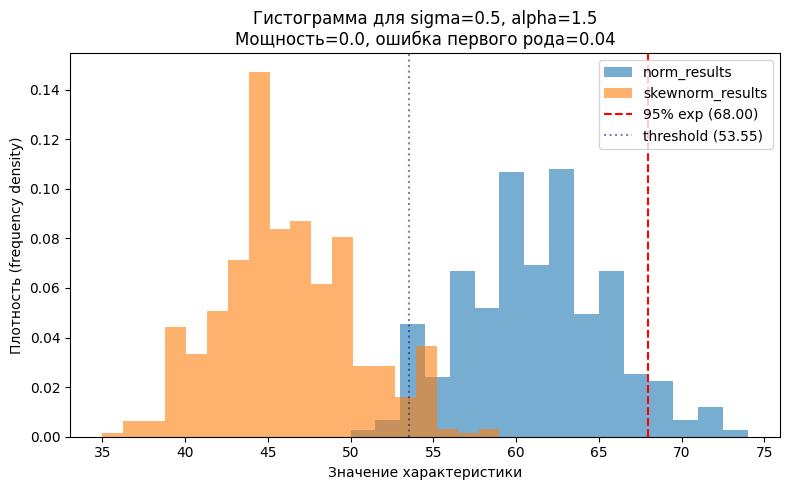

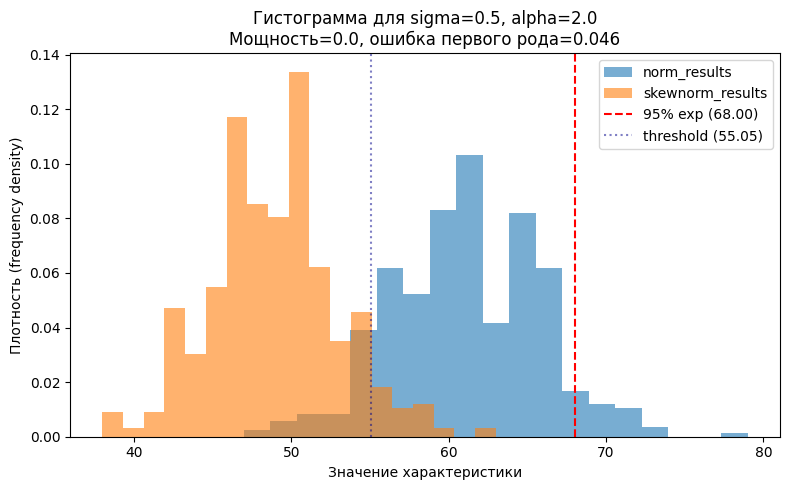

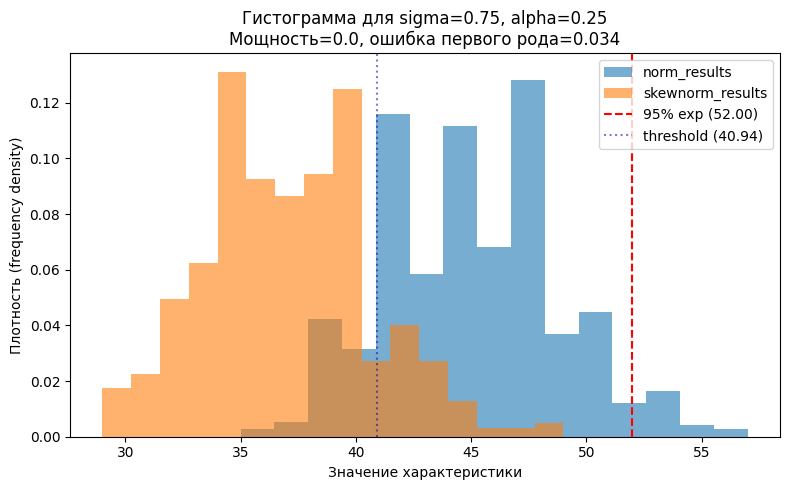

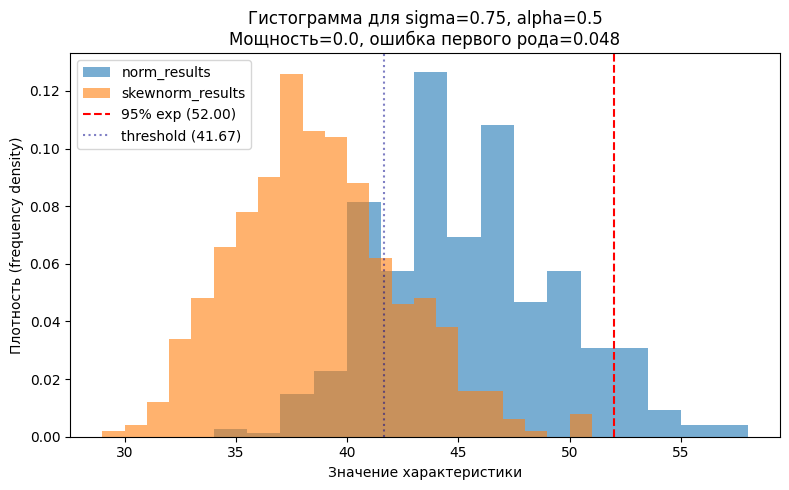

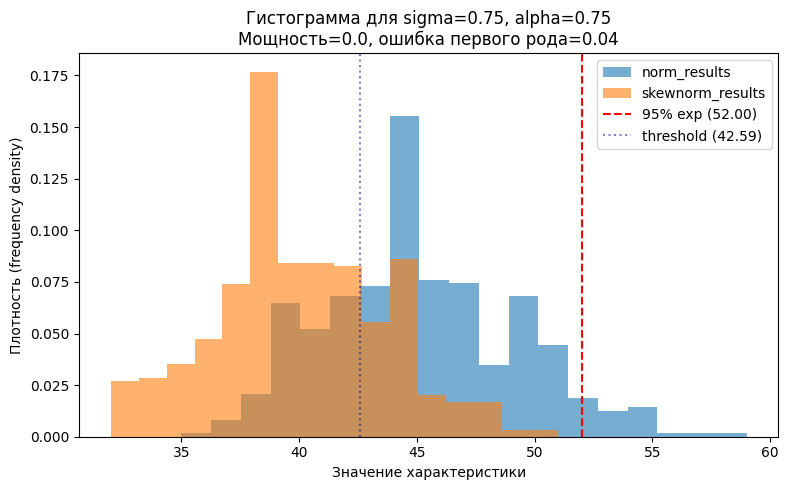

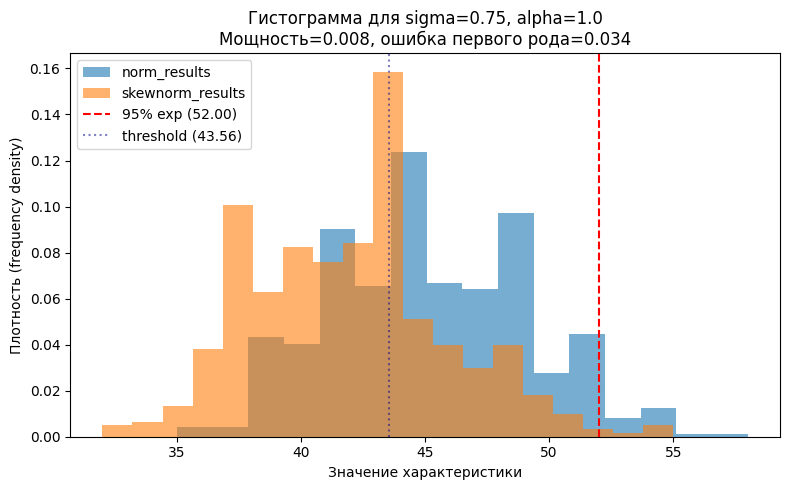

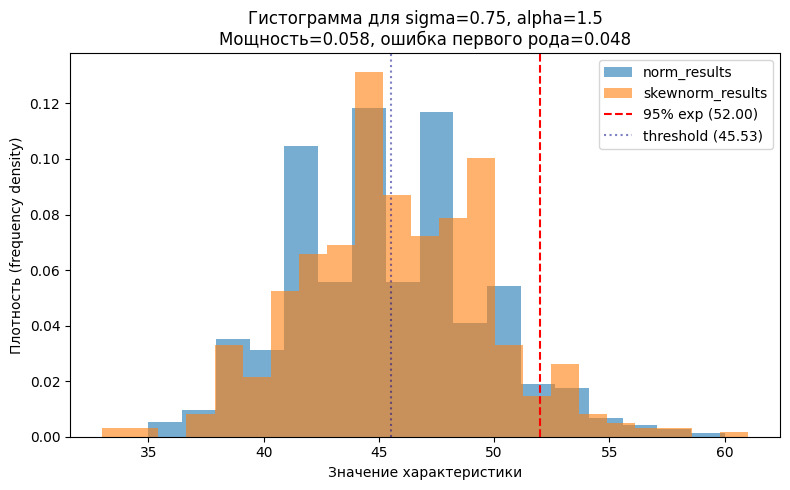

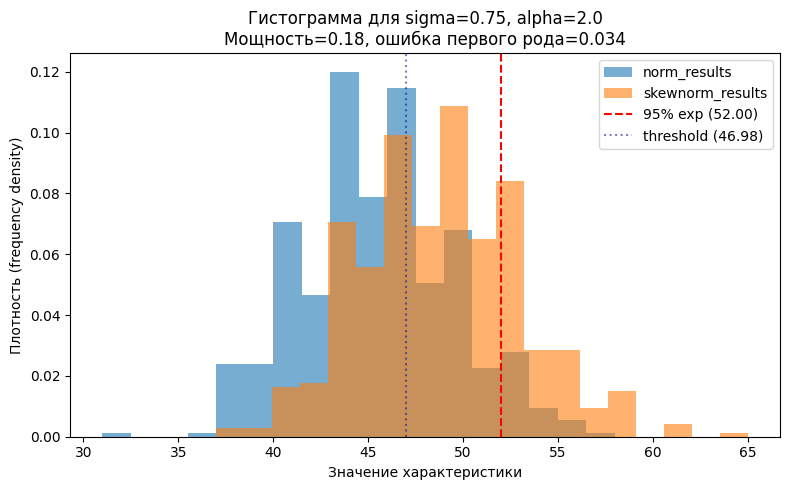

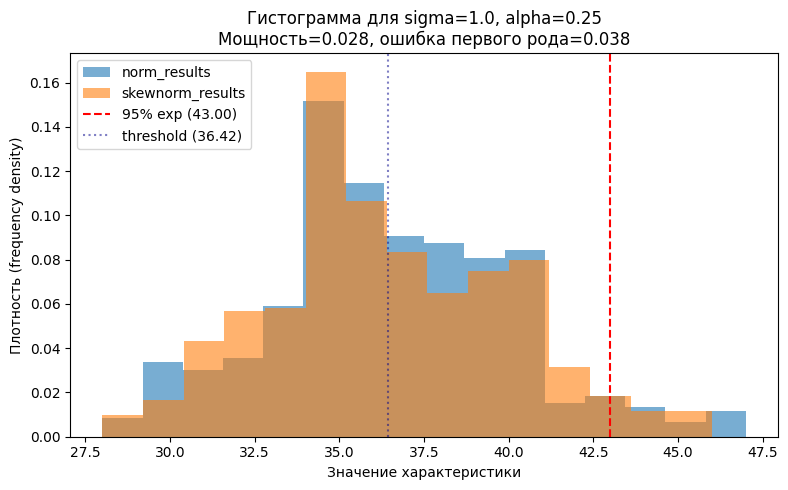

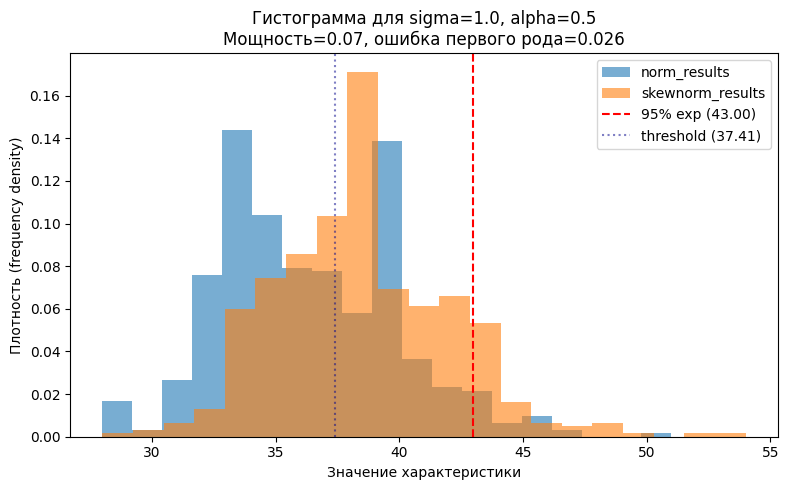

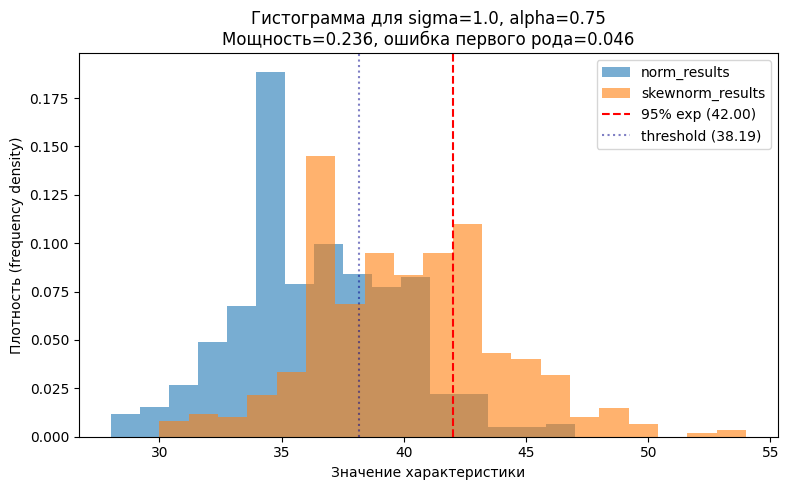

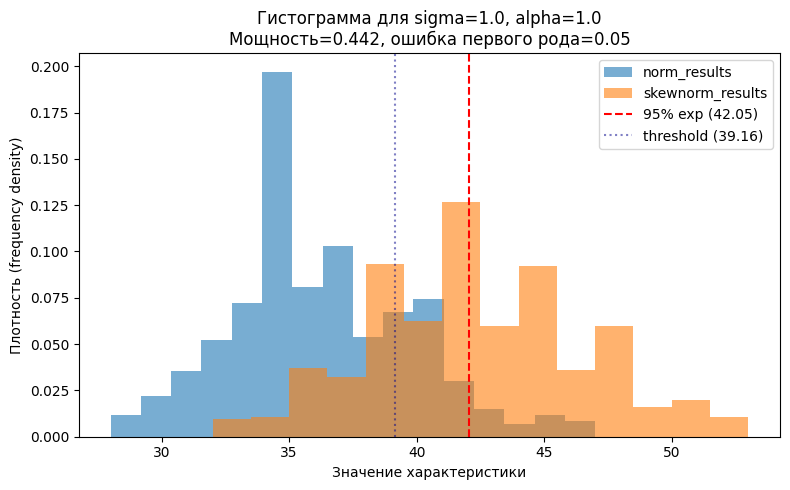

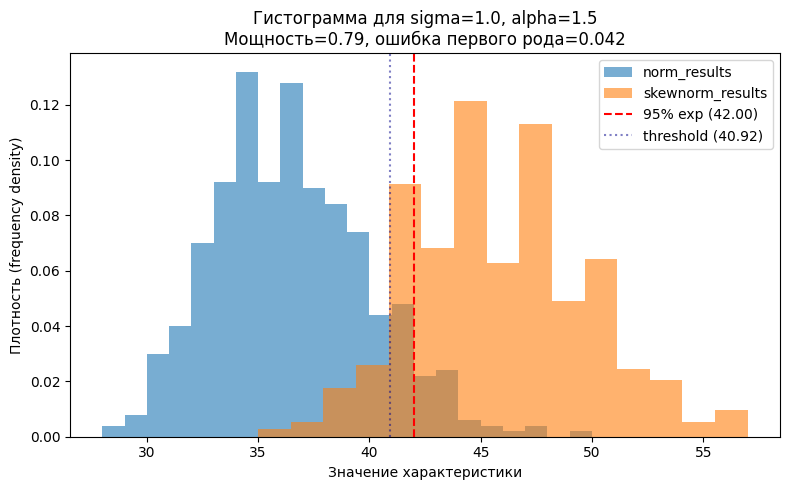

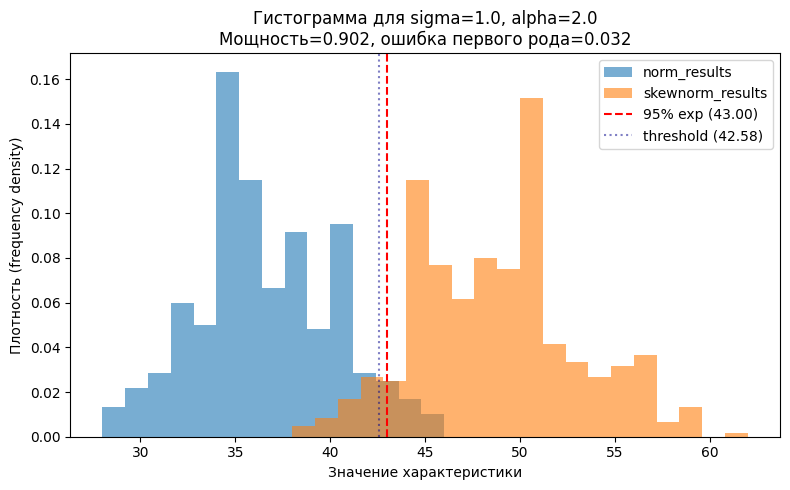

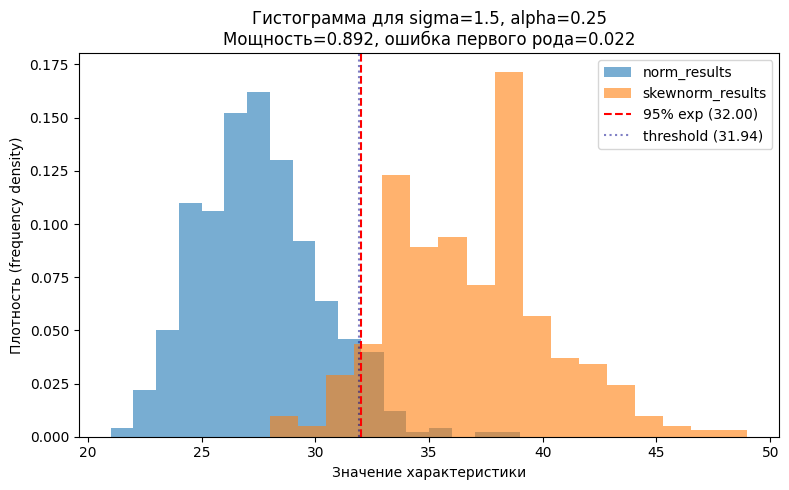

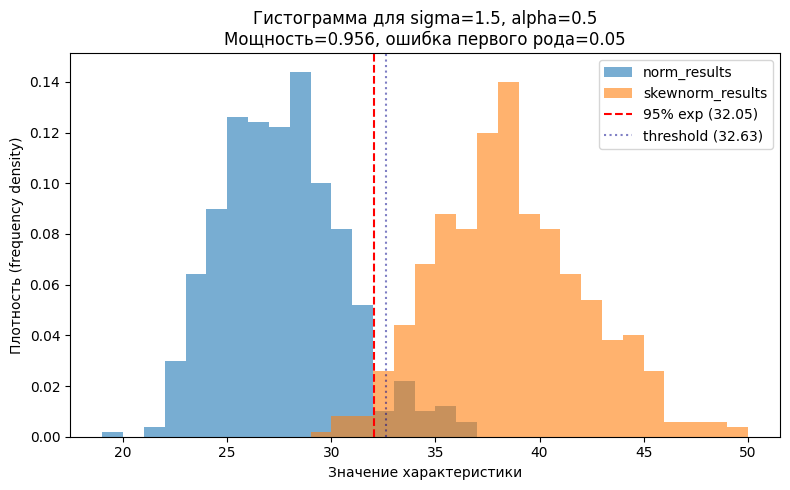

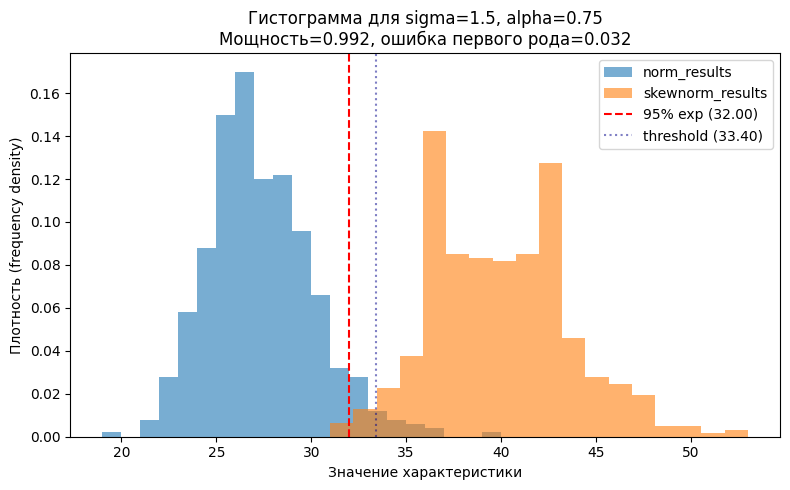

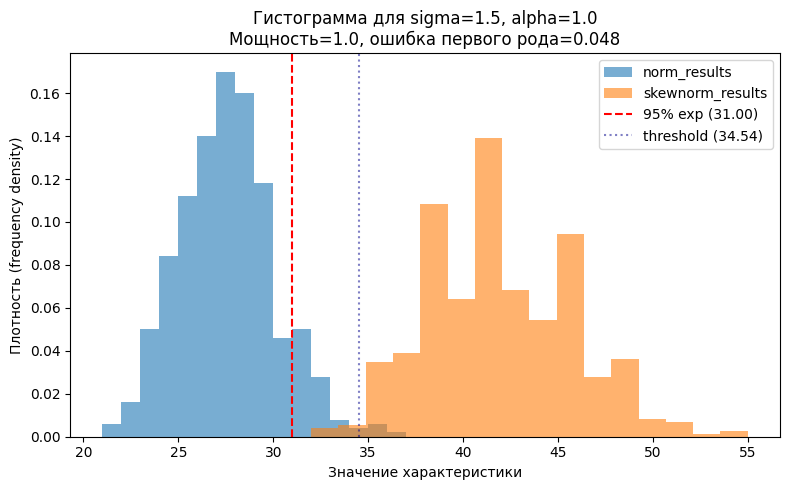

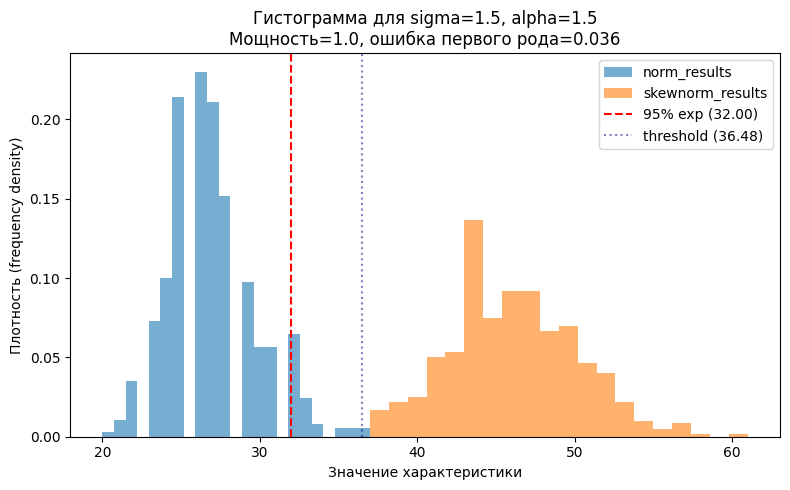

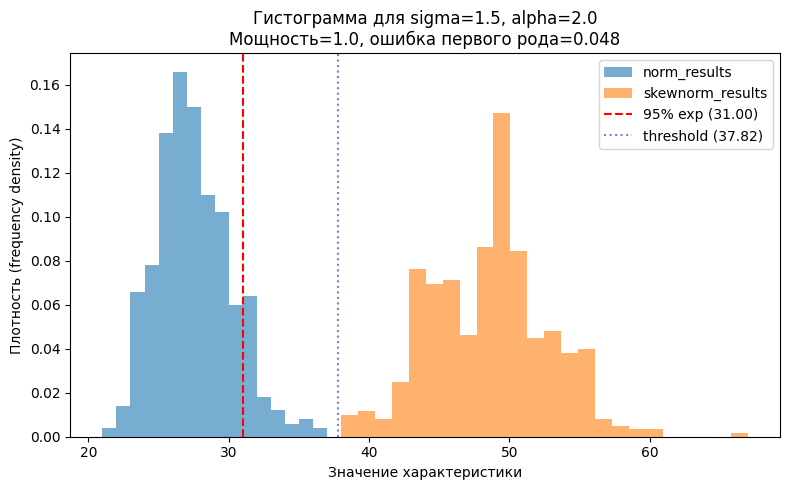

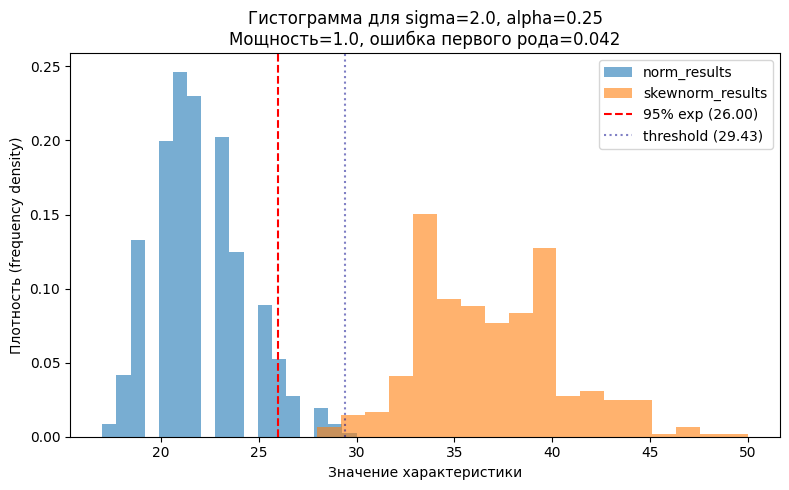

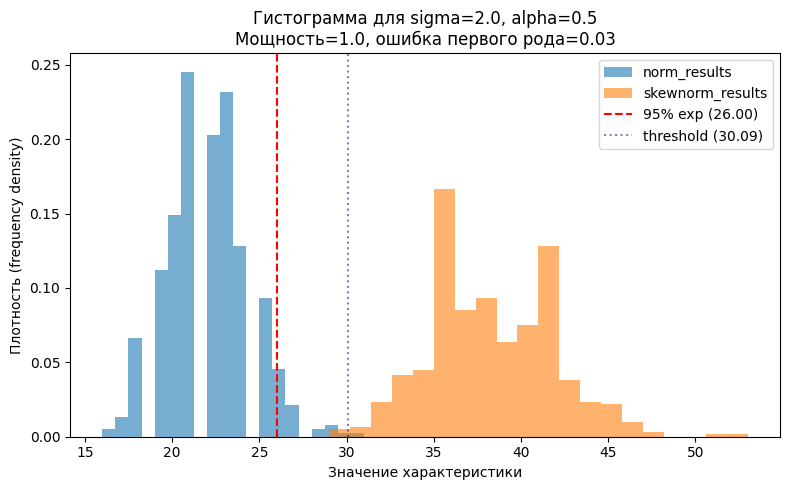

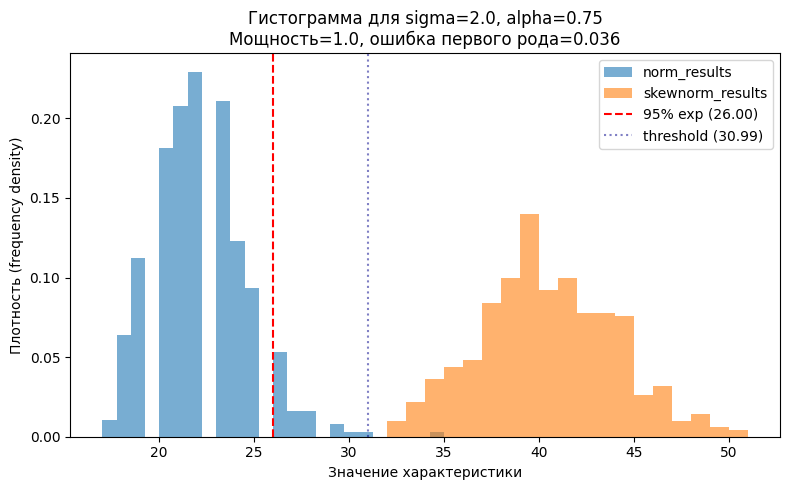

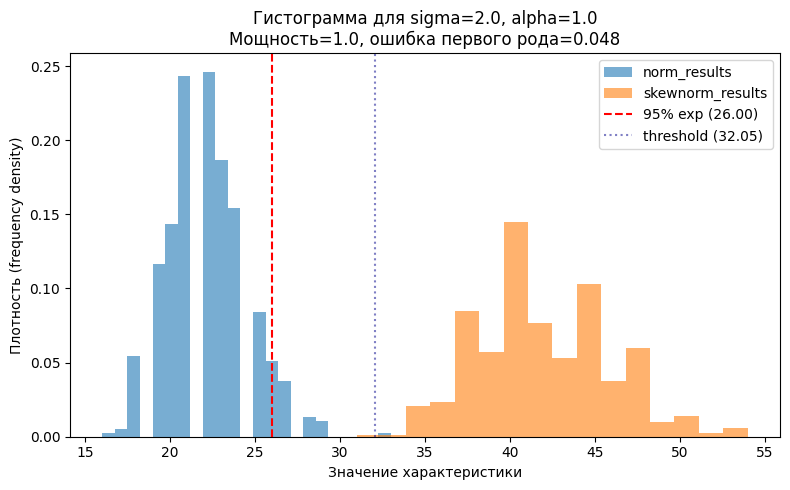

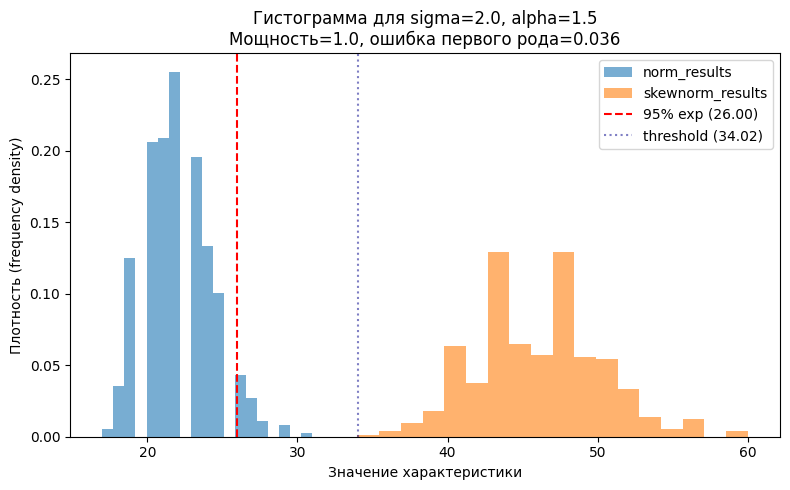

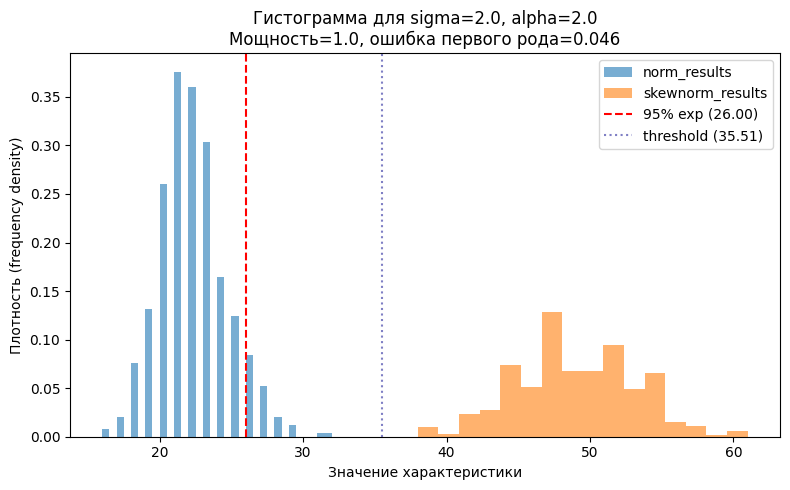

In [75]:
metrics_knn = []

for sigma in sigma_array:
    for alpha in alpha_array:
        normal_results = monte_carlo_multiprocessing(M, n, sigma, d, generate_normal, build_distance_graph, chromatic_number)
        skewnormal_results = monte_carlo_multiprocessing(M, n, alpha, d, generate_skewnormal, build_distance_graph, chromatic_number)
        metrics_knn.append(analyze_sigma_alpha(sigma, alpha, normal_results, skewnormal_results))

df_metrics = pd.DataFrame(metrics_knn)

In [76]:
df_metrics

sigma  alpha_param  power  alpha  p95_exp  threshold  mean_norm  \
0    0.25         0.25  0.000  0.016    96.00     63.698     91.070   
1    0.25         0.50  0.000  0.018    96.00     64.750     91.170   
2    0.25         0.75  0.000  0.036    95.00     65.504     90.936   
3    0.25         1.00  0.000  0.038    95.00     66.609     90.964   
4    0.25         1.50  0.000  0.016    96.00     68.574     91.078   
5    0.25         2.00  0.000  0.020    95.00     69.841     90.934   
6    0.50         0.25  0.000  0.036    69.00     48.957     61.004   
7    0.50         0.50  0.000  0.042    68.00     49.793     61.220   
8    0.50         0.75  0.000  0.050    68.05     50.832     61.682   
9    0.50         1.00  0.000  0.044    68.00     51.727     61.166   
10   0.50         1.50  0.000  0.040    68.00     53.554     60.972   
11   0.50         2.00  0.000  0.046    68.00     55.046     61.162   
12   0.75         0.25  0.000  0.034    52.00     40.937     45.000   
13   0.75         0.50  0.000  0.048    52.00     41.675     45.200   
14   0.75         0.75  0.000  0.040    52.00     42.588     45.140   
15   0.75         1.00  0.008  0.034    52.00     43.565     45.170   
16   0.75         1.50  0.058  0.048    52.00     45.531     45.328   
17   0.75         2.00  0.180  0.034    52.00     46.985     45.210   
18   1.00         0.25  0.028  0.038    43.00     36.423     36.522   
19   1.00         0.50  0.070  0.026    43.00     37.409     36.368   
20   1.00         0.75  0.236  0.046    42.00     38.186     36.378   
21   1.00         1.00  0.442  0.050    42.05     39.157     36.196   
22   1.00         1.50  0.790  0.042    42.00     40.916     35.992   
23   1.00         2.00  0.902  0.032    43.00     42.578     36.468   
24   1.50         0.25  0.892  0.022    32.00     31.941     27.024   
25   1.50         0.50  0.956  0.050    32.05     32.628     27.110   
26   1.50         0.75  0.992  0.032    32.00     33.403     26.848   
27   1.50         1.00  1.000  0.048    31.00     34.537     27.086   
28   1.50         1.50  1.000  0.036    32.00     36.478     26.932   
29   1.50         2.00  1.000  0.048    31.00     37.820     27.024   
30   2.00         0.25  1.000  0.042    26.00     29.427     22.008   
31   2.00         0.50  1.000  0.030    26.00     30.085     21.958   
32   2.00         0.75  1.000  0.036    26.00     30.987     22.034   
33   2.00         1.00  1.000  0.048    26.00     32.054     22.140   
34   2.00         1.50  1.000  0.036    26.00     34.017     22.040   
35   2.00         2.00  1.000  0.046    26.00     35.509     22.068   

     var_norm  std_norm   se_norm  mean_skewnorm  var_skewnorm  std_skewnorm  \
0    7.788677  2.790820  0.124809         36.326     12.111948      3.480222   
1    7.307715  2.703279  0.120894         38.330     14.478056      3.805004   
2    7.258421  2.694146  0.120486         40.072     13.634084      3.692436   
3    7.437579  2.727193  0.121964         42.254     15.889263      3.986134   
4    8.745407  2.957263  0.132253         46.070     18.946994      4.352814   
5    6.446537  2.539003  0.113548         48.748     17.856208      4.225661   
6   20.052088  4.477956  0.200260         36.910     13.625150      3.691226   
7   18.688978  4.323075  0.193334         38.366     12.557158      3.543608   
8   17.022922  4.125884  0.184515         39.982     14.691058      3.832892   
9   17.437319  4.175802  0.186748         42.288     15.840737      3.980042   
10  18.768754  4.332292  0.193746         46.136     16.217940      4.027150   
11  21.514786  4.638403  0.207436         48.930     16.562224      4.069671   
12  14.837675  3.851970  0.172265         36.874     12.671467      3.559700   
13  16.268537  4.033427  0.180380         38.150     13.742986      3.707153   
14  16.284970  4.035464  0.180471         40.036     13.128962      3.623391   
15  15.383868  3.922227  0.175407         41.960     15.176754      3.895735   
16  17.711840  4

**Вывод:**\
Чем больше $\alpha$ и $\sigma$, тем больше мощность. Обе переменные вносят хороший вклад в рост характеристик.\
Можно заметить, как увeличение $\alpha$ сдвигает график для $SkewNormal(α)$ правeе, увeличение $\sigma$ сдвигает график для $Normal(0,σ)$ левeе. Это факт может помочь в будущем с точностью классификации.